# Projeto Integrador Final
# Predição do Faturamento de uma distribuidora de Implementos Médicos e Medicamentos buscando prever o Faturamento para o próximo Ano.

Grupo 4: Andreia Bacic, Alex Pivato, Guilherme Butzke, João Viana e Lucas Gentile

Modelos testados: 
    1 - Tendência Linear
    2 - Tendência quadrática
    3 - Tendência com transformação logarítmica
    4 - Single Exponential Smoothing (suavização exponencial simples)
    5 - Triple Exponential Smoothing
    6 - ARIMA
    7 - SARIMA
    8 - Prophet
    9 - Xgboost
    10 - LSTM Rede Neural Recorrente
    11 - Ensemble

Instalação das bibliotecas

In [1]:
#Python - 3.9.13
#!pip install numpy==1.21.5
#!pip install pandas==1.2
#!pip install -c ana!pip tqdm
#!pip install -c ana!pip scikit-learn==1.1.0
#!pip install -c ana!pip statsmodels==0.13.2
#!pip install matplotlib==3.5.0
#!pip install -c ana!pip seaborn==0.11.2
#!pip install -c !pip-forge optuna==2.10.0
#!pip install -c !pip-forge scikit-optimize==0.9.0
#!pip install -c !pip-forge joblib==1.2.0
#!pip install -c plotly plotly
#!pip install -c !pip-forge jupyterlab
#!pip install sktime --user
#!pip install skforecast --user
#!pip install tensorflow --user
#!pip install xgboost --user
#!pip install streamlit

Carregamento das bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import math
import os
import keras
import sklearn
import matplotlib.pyplot as plt
import warnings
import logging
import pickle
import streamlit as st
import altair as alt
import pickle

warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

from pandas.tseries.offsets import DateOffset
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
import statsmodels.formula.api as smf
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from   statsmodels.tsa.holtwinters import SimpleExpSmoothing
from   statsmodels.tsa.stattools import adfuller
from   statsmodels.tsa.stattools import acf, pacf
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from   statsmodels.tsa.arima_model import ARIMA
from   statsmodels.graphics.tsaplots import plot_predict
from   statsmodels.tsa.seasonal import seasonal_decompose
from   statsmodels.tsa.seasonal import STL
from   statsmodels.tsa.holtwinters import ExponentialSmoothing

from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.datasets import load_airline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection._search import *

from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.metrics import RootMeanSquaredError
from keras.metrics import MeanSquaredError
from keras.metrics import MeanAbsolutePercentageError
from keras.optimizers import Adam

import xgboost as xgb
from   xgboost import plot_importance, plot_tree
from   xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster

pd.options.display.float_format = '{:20,.2f}'.format
plt.style.use("bmh")

Criação da função RMSE para calcular o Erro Quadrático Médio (RMSE)

def RMSE(predictions, targets):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)           
    return rmse_val 

In [3]:
df_Results = pd.DataFrame(columns = ["Model","RMSE","MAE", "MAPE (%)","Valor Anual (R$)"])
def Metricas_(predictions, targets, nome):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()
    model_RMSE = np.sqrt(mean_of_differences_squared)           
    model_MAPE = mean_absolute_percentage_error(targets, predictions).round(4)
    model_MAE  = mean_absolute_error(targets, predictions)
    nome = nome
    valor_anual = predictions.sum().round(2)
    df_Results.loc[-1] = [nome,model_RMSE,model_MAE,(model_MAPE*100),valor_anual]
    df_Results.index = df_Results.index+1
    df_Results.sort_index
    return model_MAPE*100, model_MAE, model_RMSE, nome, valor_anual


In [4]:
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# EDA - Análise Exploratória dos Dados

Carregamento dos Dados da planilha excel

In [5]:
%%time
data_location = "../Projeto Final/data/Faturamento.csv"
#data_location = "../projeto-integrador-final/data/Faturamento.csv"
data = pd.read_csv(data_location, sep = ";", encoding="latin-1", low_memory=False)

CPU times: total: 203 ms
Wall time: 200 ms


Seleção dos primeiros registros para verificação dos dados

In [6]:
data.head(5)

ANO  MES  TRIMESTRE      DESCRICAO_GRUPO  UF      CIDADE  \
0  2014    5          2            SANEANTES  SC  RIO DO SUL   
1  2014    6          2  PRODUTOS PARA SAUDE  SC  RIO DO SUL   
2  2014    7          3          LABORATORIO  SC  RIO DO SUL   
3  2016    6          2  PRODUTOS PARA SAUDE  SC  RIO DO SUL   
4  2017    1          1  PRODUTOS PARA SAUDE  SC  RIO DO SUL   

   ELEICAO_MUNICIPAL  ELEICAO_FEDERAL VARIACAO_DOLAR INFLACAO   PIB     VALOR  
0                  0                1    14,40010277     6,41   0,5   1868,99  
1                  0                1    14,40010277     6,41   0,5  27279,04  
2                  0                1    14,40010277     6,41   0,5    214,12  
3                  1                0   -12,59075524     6,29  -3,3  46374,06  
4                  0                0   -2,944132427     2,95   1,3  32043,56

Verificando o total de registros carregados

In [7]:
print("Total rows: {0}".format(len(data)))

Total rows: 164959


Verificando se colunas e linhas, se existe dados nulos, estatísticas e detalhes das colunas

In [8]:
print('\nConjunto de dados, linhas e colunas\n')
print('Shape:',data.shape)
print('\n---------------------------------------------\n')

print('\nCheck valores nulos\n')
print('Check nulos: \n')
print(pd.isnull(data).sum())
print('\n---------------------------------------------\n')

print('\nEstatísticas\n')
print(data.describe())
print('\n---------------------------------------------\n')

print('\nInformações do dataset\n')
print(data.info())
print('\n---------------------------------------------\n')



Conjunto de dados, linhas e colunas

Shape: (164959, 12)

---------------------------------------------


Check valores nulos

Check nulos: 

ANO                  0
MES                  0
TRIMESTRE            0
DESCRICAO_GRUPO      0
UF                   0
CIDADE               0
ELEICAO_MUNICIPAL    0
ELEICAO_FEDERAL      0
VARIACAO_DOLAR       0
INFLACAO             0
PIB                  0
VALOR                0
dtype: int64

---------------------------------------------


Estatísticas

                       ANO                  MES            TRIMESTRE  \
count           164,959.00           164,959.00           164,959.00   
mean              2,016.81                 6.58                 2.53   
std                   3.69                 3.26                 1.08   
min               2,008.00                 1.00                 1.00   
25%               2,014.00                 4.00                 2.00   
50%               2,017.00                 7.00                 3.00   
7

Análise da Correlação das colunas

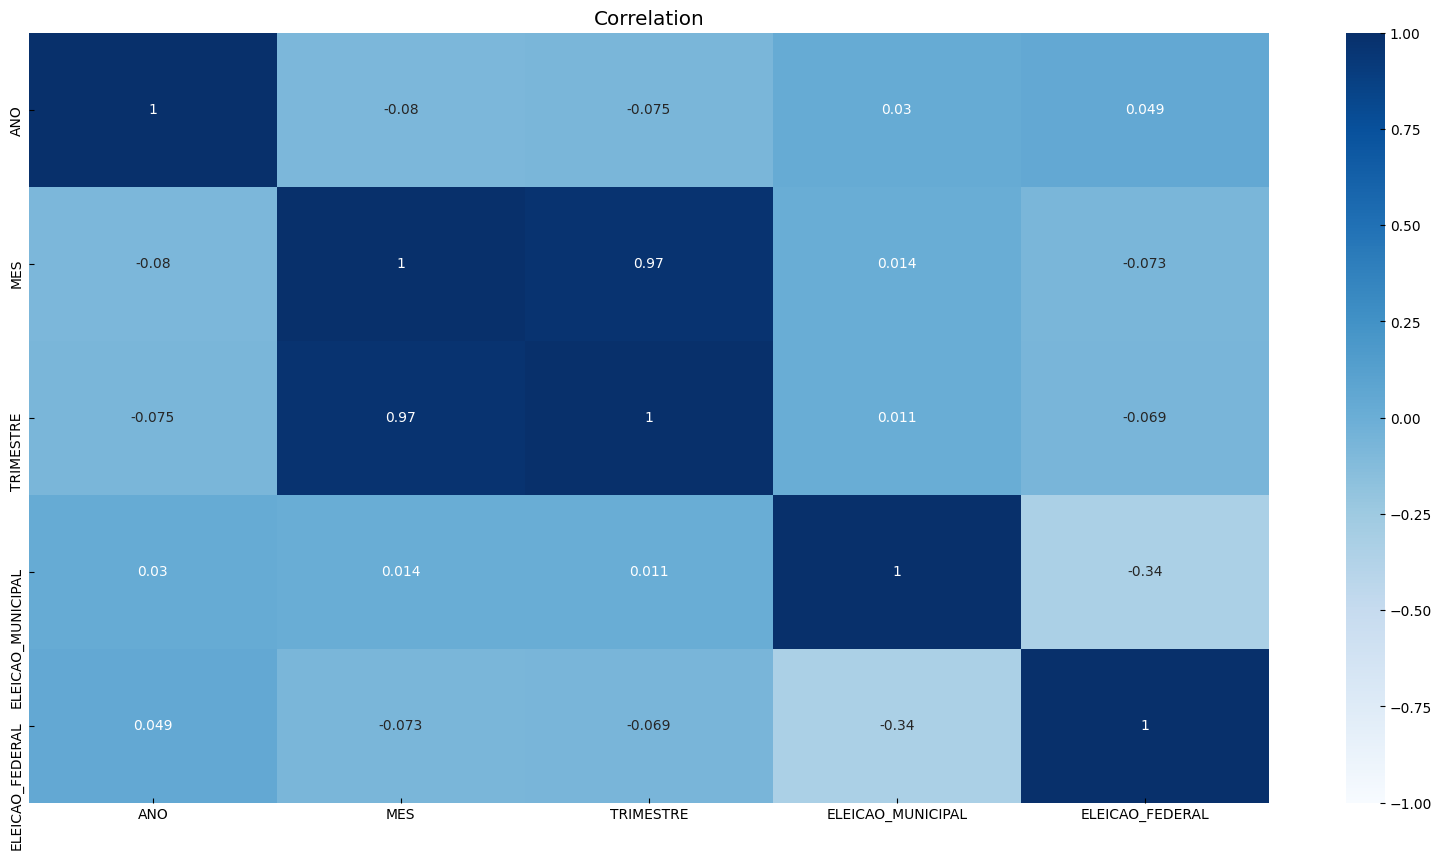

In [9]:
plt.figure(figsize = (20,10))
plt.title('Correlation')
sns.heatmap(data.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );
#plt.savefig("../Correlation1.png", dpi = 600 )

Agrupamento dos dados por Ano

In [10]:
data.groupby('ANO').sum()

MES  TRIMESTRE  ELEICAO_MUNICIPAL  ELEICAO_FEDERAL
ANO                                                        
2008    3312       1104                276                0
2009   36927      14100                  0                0
2010   41574      15852                  0             6115
2011   48681      18506                  0                0
2012   47973      18535               7457                0
2013   57444      21962                  0                0
2014   73459      27997                  0            10497
2015   80293      30666                  0                0
2016   83735      31990              12682                0
2017   96414      36683                  0                0
2018  104117      40009                  0            15799
2019  107931      41484                  0                0
2020  118680      45375              17646                0
2021  125258      48153                  0                0
2022   60038      24563                  0            12645

Alteração da coluna VALOR que é a variável target a ser observada de object para float e substituição das virgulas por .

In [11]:
data['VALOR'] =data['VALOR'].apply(lambda x: x.replace(',', '.')).astype('float')

Plot VALOR

Verificando a distribuição do Valor total vendido por cada Ano

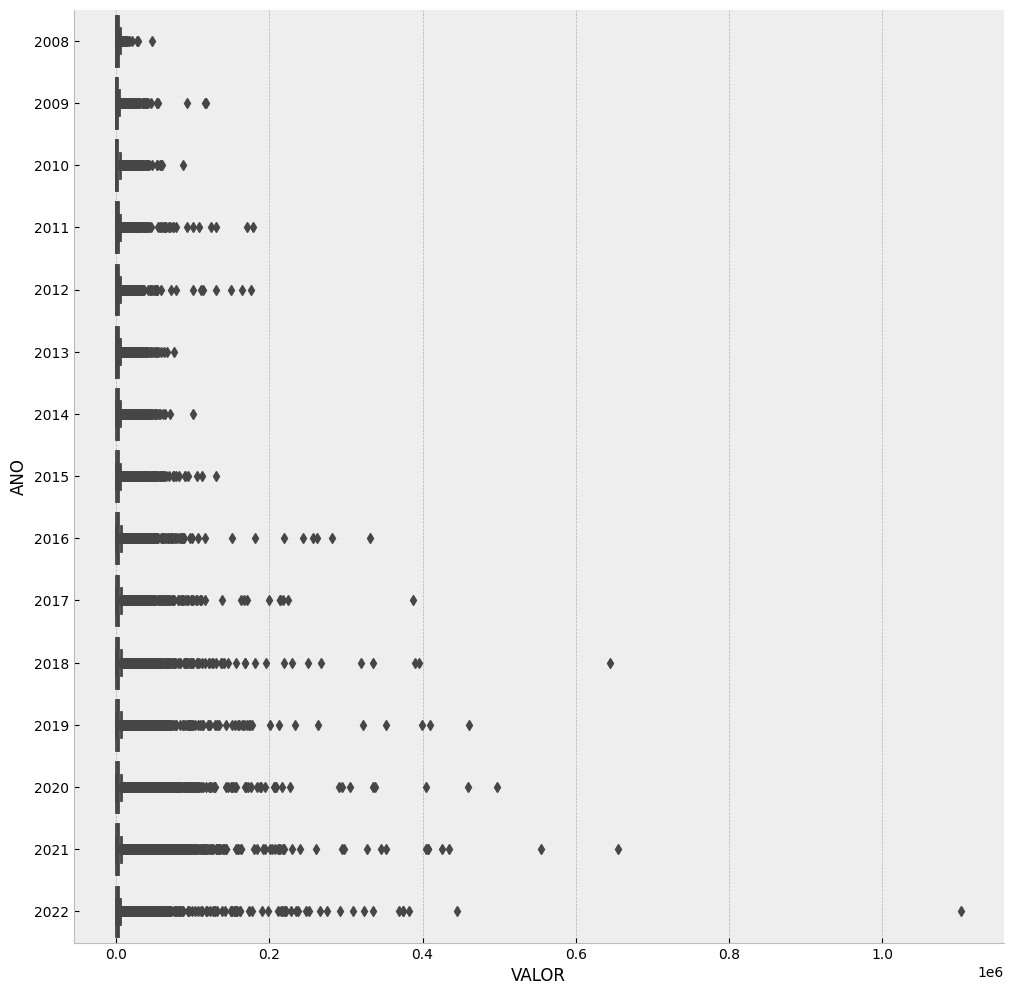

In [12]:
sns.catplot(y="ANO", x="VALOR",
                data=data.sort_values(by='ANO', ascending=False), kind="box",
                height=10, orient='h');

Análise da distribuição minimos e máximo do Valor total de vendas

In [13]:
data.VALOR.describe()

count             164,959.00
mean                3,066.55
std                11,039.93
min                     0.04
25%                   245.60
50%                   828.10
75%                 2,547.72
max             1,102,818.29
Name: VALOR, dtype: float64

Alteração do data type das colunas ANO e MES para string

In [14]:
data["ANO"] = data["ANO"].astype("str")
data["MES"] = data["MES"].astype("str")

Criação de uma nova coluna DATA concatenando o mês e o ano e convertendo para datetime

In [15]:
s_mes = data.MES
data["MES"] = s_mes.str.zfill(2)
data['DATA']= '01' + data.MES + data.ANO
data['DATA']=pd.to_datetime(data['DATA'], format='%d%m%Y')
data[['ANO','MES','DATA']]

ANO MES       DATA
0       2014  05 2014-05-01
1       2014  06 2014-06-01
2       2014  07 2014-07-01
3       2016  06 2016-06-01
4       2017  01 2017-01-01
...      ...  ..        ...
164954  2022  03 2022-03-01
164955  2022  08 2022-08-01
164956  2016  10 2016-10-01
164957  2016  10 2016-10-01
164958  2016  07 2016-07-01

[164959 rows x 3 columns]

Criação de um dataframe que será usado posteriormente para resultados finais

Agrupamento dos dados por DATA e média do VALOR

In [16]:
dt_ano = data.loc[:, ['DATA','VALOR']]

Criação dataframe com a soma das médias do Valor por anao

In [17]:
gb_ano = dt_ano.groupby('DATA')['VALOR'].sum().reset_index()

In [18]:
dt_ano_sum = pd.DataFrame(gb_ano)
dt_ano_sum['ANO']=pd.to_datetime(dt_ano_sum['DATA']).dt.year
dt_ano_sum=dt_ano_sum.drop(columns=['DATA'], axis=1)
dt_ano_sum['VALOR']=dt_ano_sum['VALOR'].round(0)
dt_ano_sum

VALOR   ANO
0             586,452.00  2008
1             446,577.00  2009
2             427,043.00  2009
3           1,032,329.00  2009
4             971,641.00  2009
..                   ...   ...
160         5,298,394.00  2022
161         6,434,291.00  2022
162         6,147,065.00  2022
163         6,217,136.00  2022
164         7,778,743.00  2022

[165 rows x 2 columns]

Criação de uma datagroup agrupando as Datas com a soma do valor total de vendas e definição do indice por DATA

In [19]:
gb_vendas = data.groupby('DATA')['VALOR'].sum().reset_index()
gb_vendas = data.set_index('DATA')

Criação do dataframe df_vendas_ano a partir de datagroup criado anteriormente.
Foi utilizada a função resample, levando a série para um espaço de tempo maior.
No nosso caso, passamos de dias para meses; MS indica "no início do mês".
E com a função mean() agrupamos todas as vendas do mês e calculamos a média.

In [20]:
df_vendas_ano = gb_vendas['VALOR'].resample('MS').sum().to_frame();
df_vendas_ano.head()

VALOR
DATA                           
2008-12-01           586,451.99
2009-01-01           446,576.62
2009-02-01           427,042.93
2009-03-01         1,032,328.70
2009-04-01           971,640.59

Ordenação dos dados pela coluna DATA

In [21]:
df_vendas_ano = df_vendas_ano.sort_values(by = "DATA")

Verificando a quatidade de colunas e linhas da série criada

In [22]:
df_vendas_ano.shape

(165, 1)

Análise gráfica da série

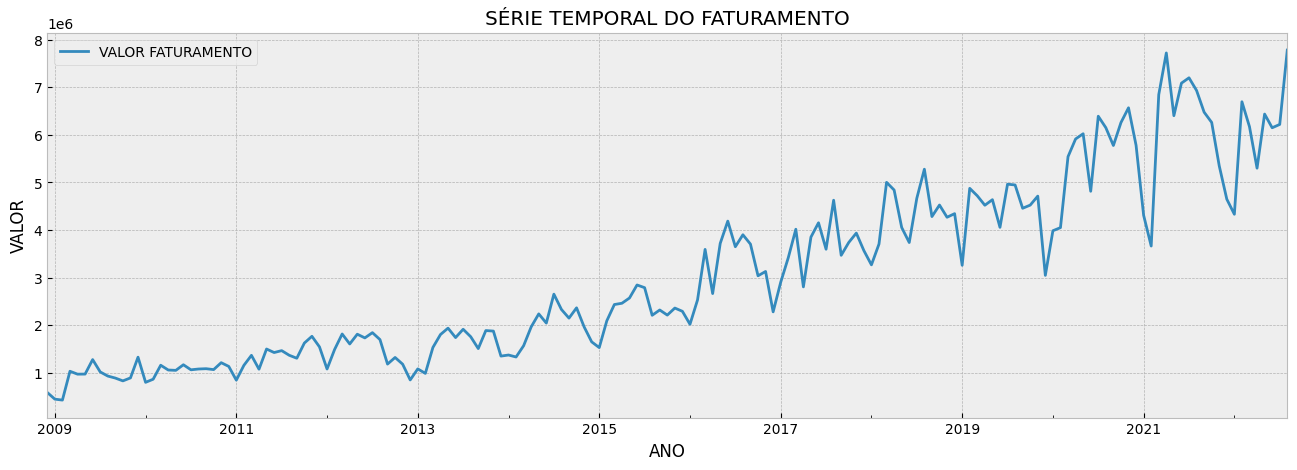

In [23]:
df_vendas_ano.plot(figsize=(16,5));
plt.xlabel('ANO')
plt.ylabel('VALOR')
plt.title('SÉRIE TEMPORAL DO FATURAMENTO')
plt.legend(['VALOR FATURAMENTO'])
#plt.savefig("../Serie Temporal.png", dpi = 600 )

Observando a decomposição da sazonalidade da serie

In [24]:
stl=STL(df_vendas_ano).fit()

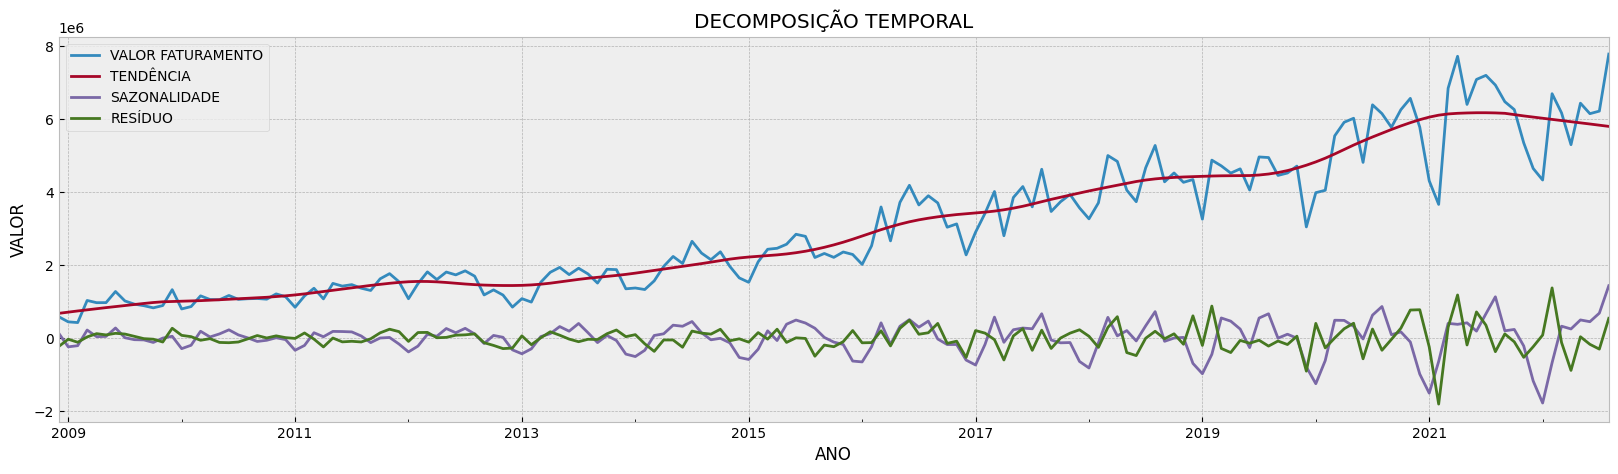

In [25]:
stl.observed.plot(figsize=(20,5))
stl.trend.plot(figsize=(20,5))
stl.seasonal.plot(figsize=(20,5))
stl.resid.plot(figsize=(20,5))
plt.title('DECOMPOSIÇÃO TEMPORAL')
plt.xlabel('ANO')
plt.ylabel('VALOR')
plt.legend(['VALOR FATURAMENTO','TENDÊNCIA','SAZONALIDADE', 'RESÍDUO'])
#plt.savefig("../Decomposição.png", dpi = 600 )

# CRIAÇÃO DOS MODELOS DE SÉRIES TEMPORAIS

# 1- Tendência Linear

Criação de um dataframe que será utilizado para o modelo de Tendencia Linear

In [26]:
df_vendas_model1 = df_vendas_ano[['VALOR']]
print('df_vendas_ano: ', df_vendas_ano.shape, 'df_vendas_model1: ', df_vendas_model1.shape)

df_vendas_ano:  (165, 1) df_vendas_model1:  (165, 1)


In [27]:
df_vendas_model1.head()

VALOR
DATA                           
2008-12-01           586,451.99
2009-01-01           446,576.62
2009-02-01           427,042.93
2009-03-01         1,032,328.70
2009-04-01           971,640.59

Fazemos a modelagem da série com time dummy DATAINDEX para o modelo de tendencia linear 

In [28]:
df_vendas_model1["DATAINDEX"] = pd.Series(np.arange(len(df_vendas_model1['VALOR'])), index = df_vendas_model1.index)
df_vendas_model1.DATAINDEX.head(3)

DATA
2008-12-01    0
2009-01-01    1
2009-02-01    2
Freq: MS, Name: DATAINDEX, dtype: int32

Verificando os primeiros registros da série

In [29]:
df_vendas_model1.head()

VALOR  DATAINDEX
DATA                                      
2008-12-01           586,451.99          0
2009-01-01           446,576.62          1
2009-02-01           427,042.93          2
2009-03-01         1,032,328.70          3
2009-04-01           971,640.59          4

Separação do modelo de treino e teste

In [30]:
df_train, df_test = train_test_split(df_vendas_model1, test_size = 12, random_state = 42, shuffle = False)

Instanciamento do modelo linear com OLS para fazer a regressão linear com duas variáveis VALOR e DATAINDEX 

In [31]:
sm.OLS.from_formula

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

In [32]:
model_linear = smf.ols(formula = 'VALOR ~ DATAINDEX', data = df_train).fit()

Geração das previsões do conjunto de treino e teste

In [33]:
df_train["LinearTrend"] = model_linear.predict(df_train.DATAINDEX)
df_test["LinearTrend"] = model_linear.predict(df_test.DATAINDEX)

Criação de um novo dataframe para armazenar as previsões do modelo

In [34]:
df_linear = model_linear.predict(df_test.DATAINDEX)
df_linear_train = df_train["LinearTrend"]
df_linear

DATA
2021-09-01           5,639,092.16
2021-10-01           5,675,483.22
2021-11-01           5,711,874.27
2021-12-01           5,748,265.32
2022-01-01           5,784,656.38
2022-02-01           5,821,047.43
2022-03-01           5,857,438.48
2022-04-01           5,893,829.54
2022-05-01           5,930,220.59
2022-06-01           5,966,611.64
2022-07-01           6,003,002.70
2022-08-01           6,039,393.75
dtype: float64

Análise gráfica das predições do treino e teste

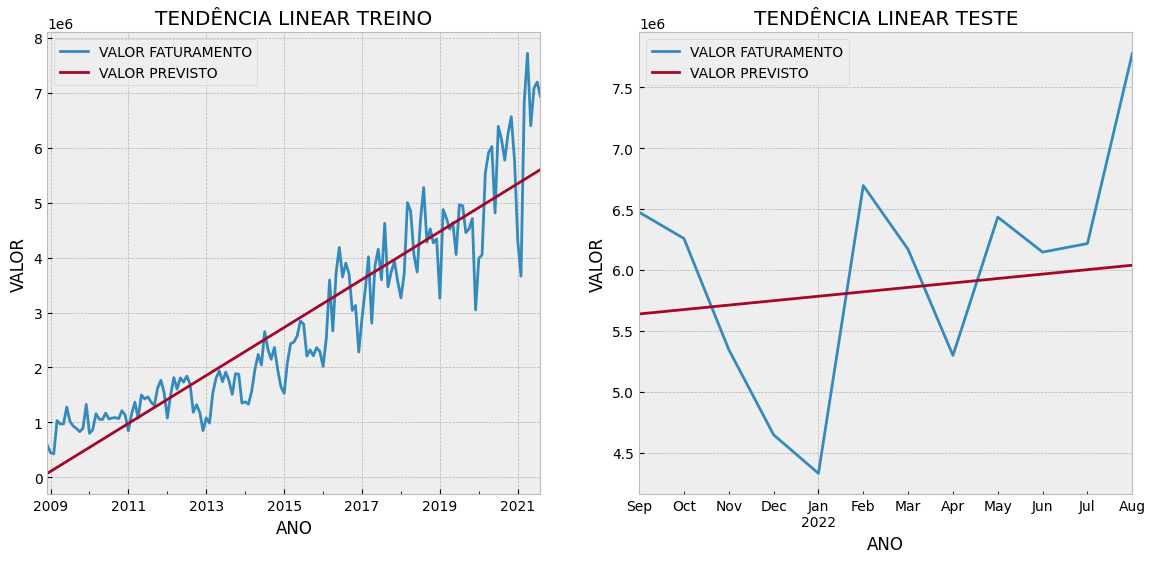

In [35]:
fig, axes = plt.subplots(1, 2,figsize = (14, 6))
df_train.plot(kind = "line", y = ["VALOR","LinearTrend"], ax = axes[0], title = 'TENDÊNCIA LINEAR TREINO');
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
df_test.plot(kind = "line", y = ["VALOR","LinearTrend"], ax = axes[1], title = 'TENDÊNCIA LINEAR TESTE');
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../Tendencia Linear.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [36]:
Metricas_(df_test['LinearTrend'], df_test['VALOR'], 'Tendência Linear')

(12.690000000000001,
 729726.8655020436,
 869372.8767949678,
 'Tendência Linear',
 70070915.48)

Colocando as metricas dentro de um dataframe

In [37]:
df_Results

Model                 RMSE                  MAE  \
0  Tendência Linear           869,372.88           729,726.87   

              MAPE (%)     Valor Anual (R$)  
0                12.69        70,070,915.48

Resultado do modelo Linear Trend com summary 

In [38]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALOR   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     871.3
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.37e-64
Time:                        13:18:15   Log-Likelihood:                -2269.4
No. Observations:                 153   AIC:                             4543.
Df Residuals:                     151   BIC:                             4549.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.126e+04   1.08e+05      0.658      0.512   -1.43e+05    2.85e+05
DATAINDEX   3.639e+04   1232.864     29.518      0.000     3.4e+04    3.88e+04
==============================================================================
Omnibus:                        2.133   Durbin-Watson:                   0.800
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                1.701
Skew:                           0.166   Prob(JB):                        0.427
Kurtosis:                       3.396   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2 - Tendência quadrática

Elevamos a dummy de tempo DATAINDEX ao quadrado para fazer o modelo de Tendencia quadrática

In [39]:
df_vendas_model1["DATAINDEX_SQ"] = df_vendas_model1["DATAINDEX"] ** 2
df_vendas_model1.DATAINDEX_SQ.head(3)

DATA
2008-12-01    0
2009-01-01    1
2009-02-01    4
Freq: MS, Name: DATAINDEX_SQ, dtype: int32

Separação dos dados de treino e teste

In [40]:
df_train, df_test = train_test_split(df_vendas_model1, test_size = 12, random_state = 42, shuffle = False)

Adicionamos a variável da tendencia quadrática criada acima na fórmula do modelo

In [41]:
model_quadratic = smf.ols('VALOR ~ DATAINDEX + DATAINDEX_SQ', data = df_train).fit()

Geramos as previsões do modelo

In [42]:
df_train["QUADRATIC_TEND"] = model_quadratic.predict(df_train[["DATAINDEX","DATAINDEX_SQ"]])
df_test["QUADRATIC_TEND"] = model_quadratic.predict(df_test[["DATAINDEX","DATAINDEX_SQ"]])

Representação gráfica das previsões do modelo de tendencia quadrática

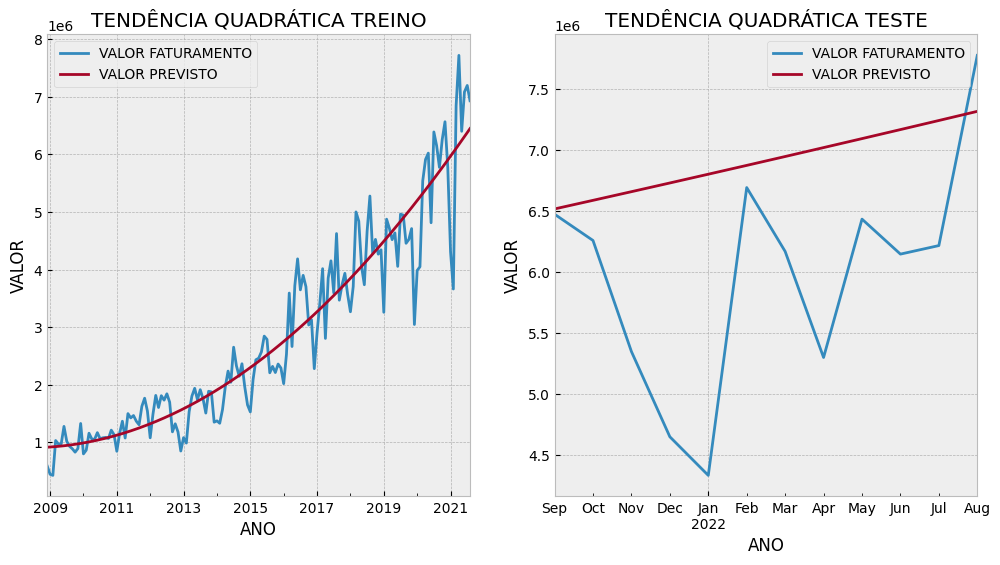

In [43]:
fig, axes = plt.subplots(1, 2,figsize = (12, 6))
df_train.plot(kind = "line", y = ["VALOR","QUADRATIC_TEND"], ax = axes[0], title = 'TENDÊNCIA QUADRÁTICA TREINO');
df_test.plot(kind = "line", y = ["VALOR","QUADRATIC_TEND"], ax = axes[1], title = 'TENDÊNCIA QUADRÁTICA TESTE');
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../Tendendia Quadratica.png", dpi = 600 )

df_testCalculamos o desempenho com as métricas RMSE, MAPE, MAE

In [44]:
Metricas_(df_test['QUADRATIC_TEND'], df_test['VALOR'], 'Tendendia Quadratica')

(19.139999999999997,
 1008080.0324018445,
 1246642.4176015959,
 'Tendendia Quadratica',
 82974067.93)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [45]:
df_Results

Model                 RMSE                  MAE  \
1      Tendência Linear           869,372.88           729,726.87   
0  Tendendia Quadratica         1,246,642.42         1,008,080.03   

              MAPE (%)     Valor Anual (R$)  
1                12.69        70,070,915.48  
0                19.14        82,974,067.93

Resultado da tendencia quadrática com summary

In [46]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALOR   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     684.8
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           3.76e-76
Time:                        13:18:15   Log-Likelihood:                -2238.6
No. Observations:                 153   AIC:                             4483.
Df Residuals:                     150   BIC:                             4492.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     9.163e+05   1.32e+05      6.929      0.000    6.55e+05    1.18e+06
DATAINDEX     2813.2553   4020.215      0.700      0.485   -5130.308    1.08e+04
DATAINDEX_SQ   220.9066     25.599      8.630      0.000     170.326     271.487
==============================================================================
Omnibus:                       33.190   Durbin-Watson:                   1.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.494
Skew:                          -0.863   Prob(JB):                     2.72e-19
Kurtosis:                       6.230   Cond. No.                     3.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3 -  Tendência com transformação logarítmica

Geramos o modelo sobre o logaritmo das vendas e suas previsões.

In [47]:
df_train['LOG_VALOR'] = np.log(df_train['VALOR'])
df_test['LOG_VALOR'] = np.log(df_test['VALOR'])

Observamos o valores de treino e teste com a calculo logarítimo

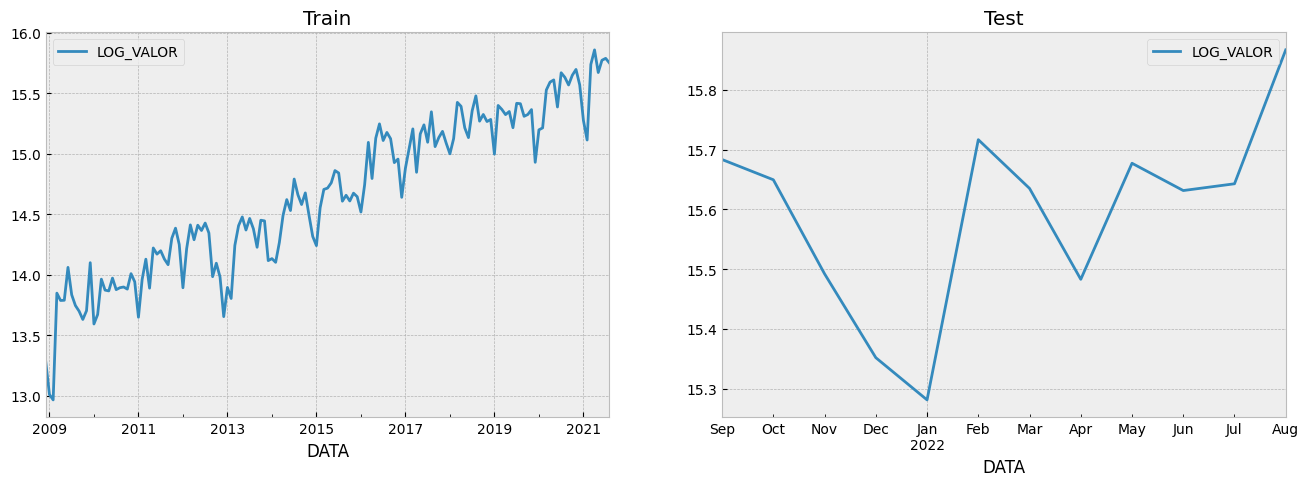

In [48]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_train.plot(kind = "line", y = ["LOG_VALOR"], ax = axes[0], title = 'Train');
df_test.plot(kind = "line", y = ["LOG_VALOR"], ax = axes[1], title = 'Test');
plt.show()

Geramos o modelo de regressão linear usando o logarítimo do valor

In [49]:
model_log = smf.ols('LOG_VALOR ~ DATAINDEX ', data = df_train).fit()

É feita a previsão dos modelos treino e teste das variáveis logarítima

In [50]:
df_train["LOG_TREND"] = model_log.predict(df_train[["DATAINDEX"]])
df_test["LOG_TREND"] = model_log.predict(df_test[["DATAINDEX"]])

Recuperamos o valor previsto do valor aplicando a função exponencial nas previsões.

In [51]:
df_train['BACK_LOG_TREND'] = np.exp(df_train['LOG_TREND'])
df_test['BACK_LOG_TREND'] = np.exp(df_test['LOG_TREND'])

Representação gráfica das previsões do modelo com transformação logarítima

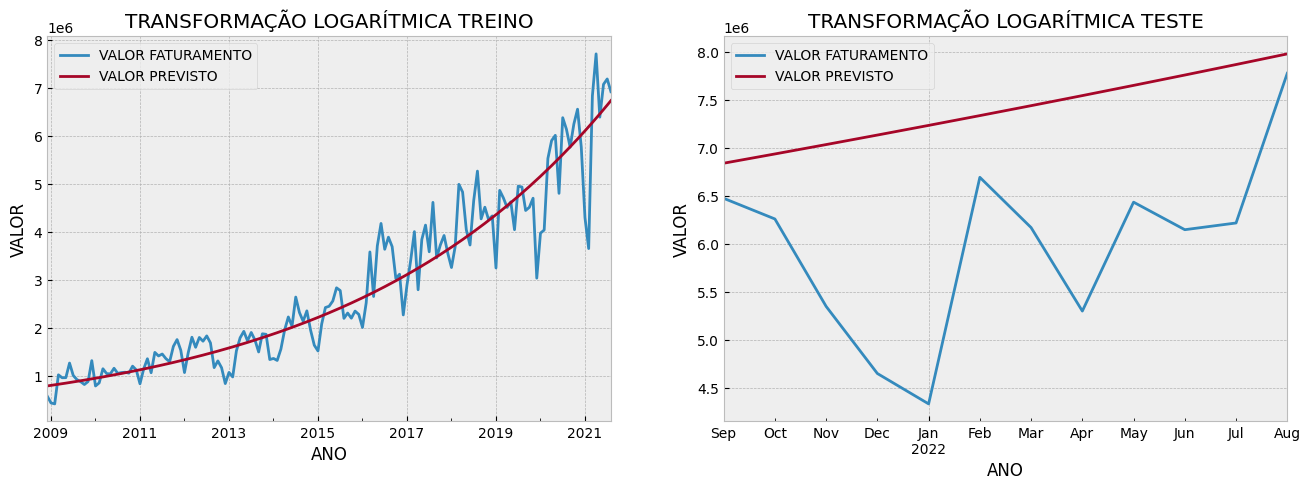

In [52]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_train.plot(kind = "line", y = ["VALOR", "BACK_LOG_TREND"], ax = axes[0], title = 'TRANSFORMAÇÃO LOGARÍTMICA TREINO');
df_test.plot(kind = "line", y = ["VALOR", "BACK_LOG_TREND"], ax = axes[1], title = 'TRANSFORMAÇÃO LOGARÍTMICA TESTE');
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../Transformação Logarítmica.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE 

In [53]:
Metricas_(df_test['BACK_LOG_TREND'], df_test['VALOR'], 'Transformação Logarítmica')

(26.3,
 1414324.8625771217,
 1633104.438988068,
 'Transformação Logarítmica',
 88768133.84)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [54]:
df_Results

Model                 RMSE                  MAE  \
2           Tendência Linear           869,372.88           729,726.87   
1       Tendendia Quadratica         1,246,642.42         1,008,080.03   
0  Transformação Logarítmica         1,633,104.44         1,414,324.86   

              MAPE (%)     Valor Anual (R$)  
2                12.69        70,070,915.48  
1                19.14        82,974,067.93  
0                26.30        88,768,133.84

# 4 - Single Exponential Smoothing

Definimos 3 valores para os fatores de suavização 0.3, 0.5 e 0.8 para analisar qual modelo traz o melhor resultado

In [55]:
model_exp_smoothing_03 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.3, optimized = False)
model_exp_smoothing_05 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.5, optimized = False)
model_exp_smoothing_08 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.8, optimized = False)

Previsão do modelo de teste com os 3 fatores de suavização

In [56]:
df_test["Simple Smoothing 03"] = model_exp_smoothing_03.forecast(len(df_test))
df_test["Simple Smoothing 05"] = model_exp_smoothing_05.forecast(len(df_test))
df_test["Simple Smoothing 08"] = model_exp_smoothing_08.forecast(len(df_test))

Observamos no treino os resultados com os três fatores de suavização

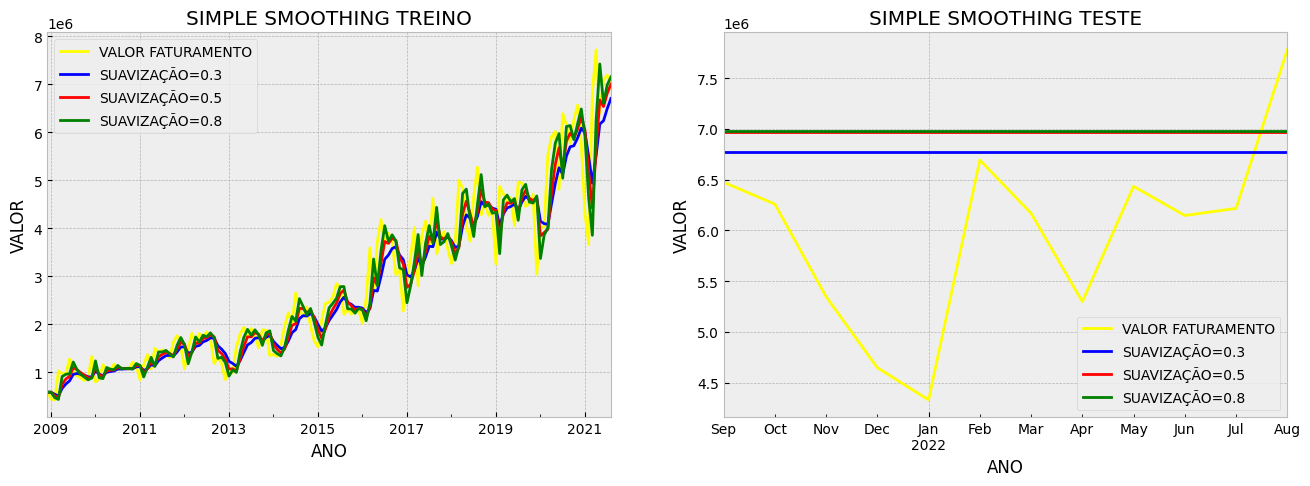

In [57]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_train.plot(kind = "line", label = "VALOR FATURAMENTO",y = "VALOR", color = 'yellow',ax = axes[0])
df_test.plot(kind = "line", label = "VALOR FATURAMENTO",y = "VALOR", color = 'yellow',ax = axes[1])
model_exp_smoothing_03.fittedvalues.plot(label = "SUAVIZAÇÃO=0.3", color = 'b', xlabel='ANO', ylabel='VALOR',ax = axes[0])
model_exp_smoothing_05.fittedvalues.plot(label = "SUAVIZAÇÃO=0.5", color = 'r', xlabel='ANO', ylabel='VALOR',ax = axes[0])
model_exp_smoothing_08.fittedvalues.plot(label = "SUAVIZAÇÃO=0.8", color = 'g', xlabel='ANO', ylabel='VALOR',ax = axes[0])
axes[0].set_title('SIMPLE SMOOTHING TREINO')
axes[0].legend();
df_test["Simple Smoothing 03"].plot(label = "SUAVIZAÇÃO=0.3", color = 'b', xlabel='ANO', ylabel='VALOR',ax = axes[1])
df_test["Simple Smoothing 05"].plot(label = "SUAVIZAÇÃO=0.5", color = 'r', xlabel='ANO', ylabel='VALOR',ax = axes[1])
df_test["Simple Smoothing 08"].plot(label = "SUAVIZAÇÃO=0.8", color = 'g', xlabel='ANO', ylabel='VALOR',ax = axes[1])
axes[1].set_title('SIMPLE SMOOTHING TESTE')
axes[1].legend();
#plt.savefig("../model_exp_smoothing_treino.png", dpi = 600 )


Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [58]:
Metricas_(df_test['Simple Smoothing 03'], df_test['VALOR'], 'Simple Smoothing 03')
Metricas_(df_test['Simple Smoothing 05'], df_test['VALOR'], 'Simple Smoothing 05')
Metricas_(df_test['Simple Smoothing 08'], df_test['VALOR'], 'Simple Smoothing 08')

(21.18,
 1126227.4251860364,
 1340795.3713884277,
 'Simple Smoothing 08',
 83704174.09)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [59]:
df_Results

Model                 RMSE                  MAE  \
5           Tendência Linear           869,372.88           729,726.87   
4       Tendendia Quadratica         1,246,642.42         1,008,080.03   
3  Transformação Logarítmica         1,633,104.44         1,414,324.86   
2        Simple Smoothing 03         1,198,540.18           957,294.34   
1        Simple Smoothing 05         1,334,673.92         1,119,321.77   
0        Simple Smoothing 08         1,340,795.37         1,126,227.43   

              MAPE (%)     Valor Anual (R$)  
5                12.69        70,070,915.48  
4                19.14        82,974,067.93  
3                26.30        88,768,133.84  
2                18.14        81,271,537.72  
1                21.06        83,604,732.71  
0                21.18        83,704,174.09

# 5 Triple Exponential Smoothing

Divisão do treino e teste, definindo a previsão de 12 meses

In [60]:
test_months = 12
training_set = df_vendas_ano.iloc[:-test_months, :]
test_set = df_vendas_ano.iloc[-test_months:, :]

Estanciando o modelo Triple Exponential Smoothing

In [61]:
model = ExponentialSmoothing(endog = training_set.VALOR,
                             trend = 'add',
                             seasonal = 'mul',
                            seasonal_periods = 30).fit()

C:\Users\alexs\anaconda3\envs\ProjetoFInal\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Gerando as previsões do modelo

In [62]:
predictions_hw = model.forecast(steps = len(test_set)).rename("HW")
treino_hw = model.fittedvalues
predictions_hw

2021-09-01           6,920,446.02
2021-10-01           7,188,506.71
2021-11-01           7,628,603.70
2021-12-01           6,442,453.50
2022-01-01           6,959,497.09
2022-02-01           7,372,087.29
2022-03-01           7,659,075.26
2022-04-01           6,944,885.21
2022-05-01           7,364,113.92
2022-06-01           6,480,653.92
2022-07-01           6,508,671.52
2022-08-01           7,212,642.61
Freq: MS, Name: HW, dtype: float64

Plot da previsão gerada pelo modelo

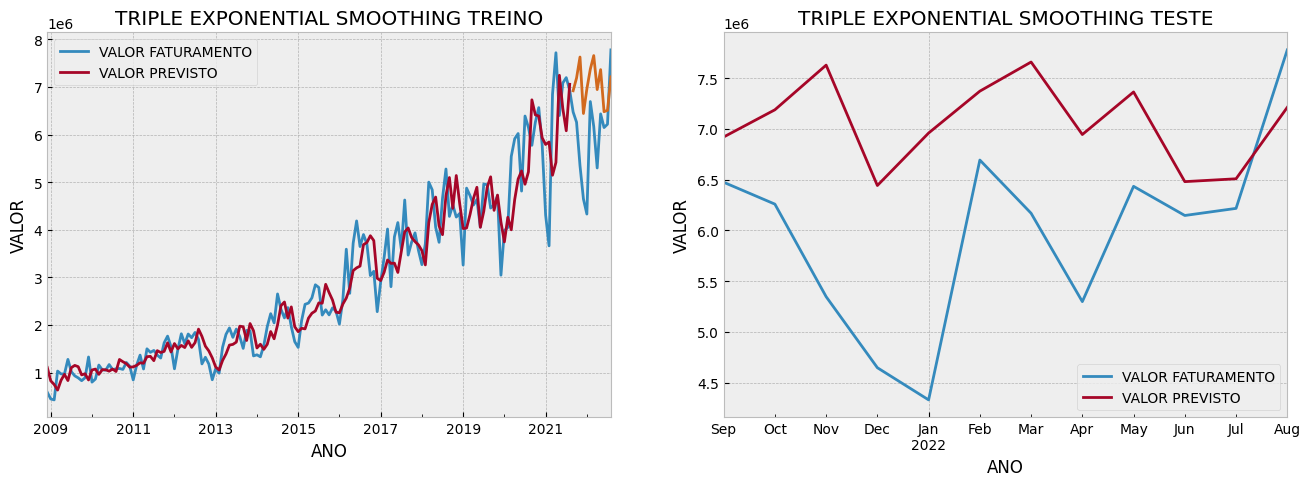

In [63]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
treino_hw.plot(ax = axes[0])
predictions_hw.plot(ax = axes[0], color = 'chocolate')
test_set['VALOR'].plot(ax = axes[1])
predictions_hw.plot(ax = axes[1])
axes[0].set_title('TRIPLE EXPONENTIAL SMOOTHING TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('TRIPLE EXPONENTIAL SMOOTHING TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../TRIPLE EXPONENTIAL SMOOTHING.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [64]:
Metricas_(predictions_hw, df_test['VALOR'], 'Triple Exponential Smoothing')

(21.75,
 1168133.5180421274,
 1389749.1404685914,
 'Triple Exponential Smoothing',
 84681636.74)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [65]:
df_Results

Model                 RMSE                  MAE  \
6              Tendência Linear           869,372.88           729,726.87   
5          Tendendia Quadratica         1,246,642.42         1,008,080.03   
4     Transformação Logarítmica         1,633,104.44         1,414,324.86   
3           Simple Smoothing 03         1,198,540.18           957,294.34   
2           Simple Smoothing 05         1,334,673.92         1,119,321.77   
1           Simple Smoothing 08         1,340,795.37         1,126,227.43   
0  Triple Exponential Smoothing         1,389,749.14         1,168,133.52   

              MAPE (%)     Valor Anual (R$)  
6                12.69        70,070,915.48  
5                19.14        82,974,067.93  
4                26.30        88,768,133.84  
3                18.14        81,271,537.72  
2                21.06        83,604,732.71  
1                21.18        83,704,174.09  
0                21.75        84,681,636.74

# 6 ARIMA

Verificando se a série é ou não estacionária com adfuller

In [66]:
def adfuller_test(vendas):
    result=adfuller(vendas)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [67]:
adfuller_test(df_vendas_ano['VALOR'])

ADF Test Statistic : 0.7057957732261546
p-value : 0.9899528272545894
#Lags Used : 10
Number of Observations : 154
weak evidence against null hypothesis,indicating it is non-stationary 


O valor de p obtido é superior ao nível de significância de 0,05 e a estatística ADF é superior a qualquer um dos valores críticos.
Portanto, não há razão para rejeitar a hipótese nula. Então, a série temporal é de fato não estacionária.
Então, no nosso caso, P Value > 0,05, prosseguimos com a determinação da ordem de diferenciação.

Função para plot do teste Dicket-Fuller, Análise do número p de lags (AR) para prever e do número do q (MA) derros de previsão defasados

In [68]:
def tsplot(y, lags = None, figsize = (12, 7), style = 'bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (2, 2)
        
        # definimos eixos
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtém o valor p com h0: raiz unitária presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análise da Série de Tempo\Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelação
        sm.graphics.tsa.plot_acf(y, lags = lags, ax = acf_ax)
        # plot de autocorrelação parcial
        sm.graphics.tsa.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série original 

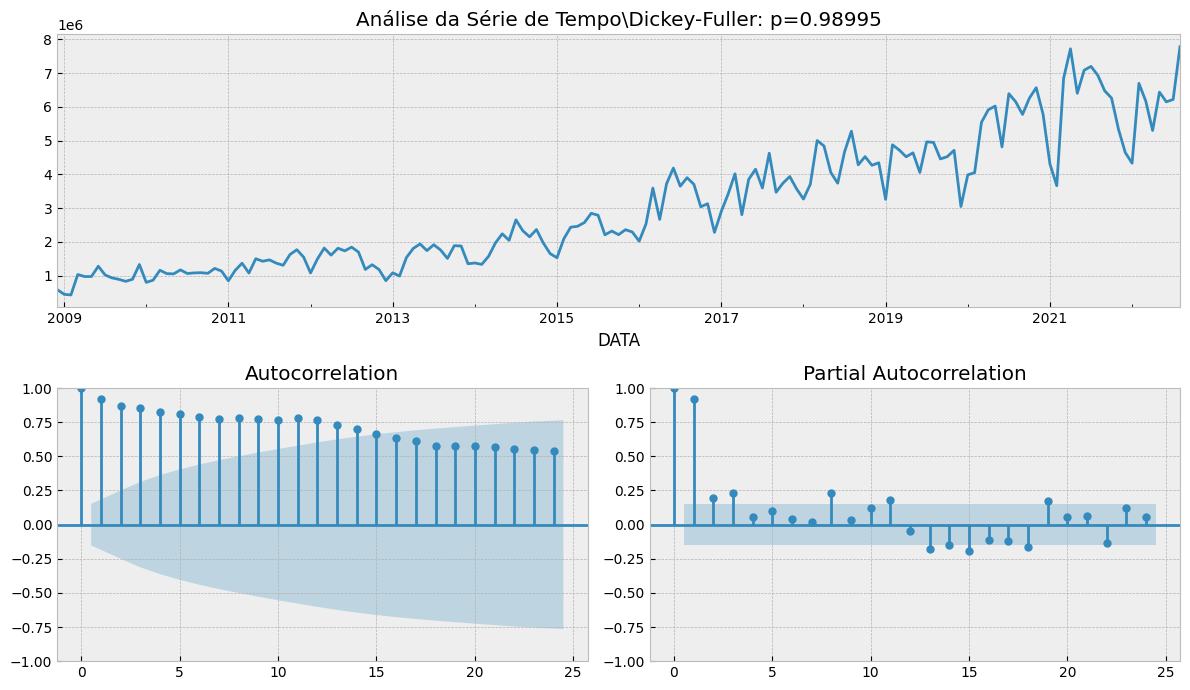

In [69]:
tsplot(df_vendas_ano.VALOR, lags = 24)

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série temporal com uma ordem de diferenciação.

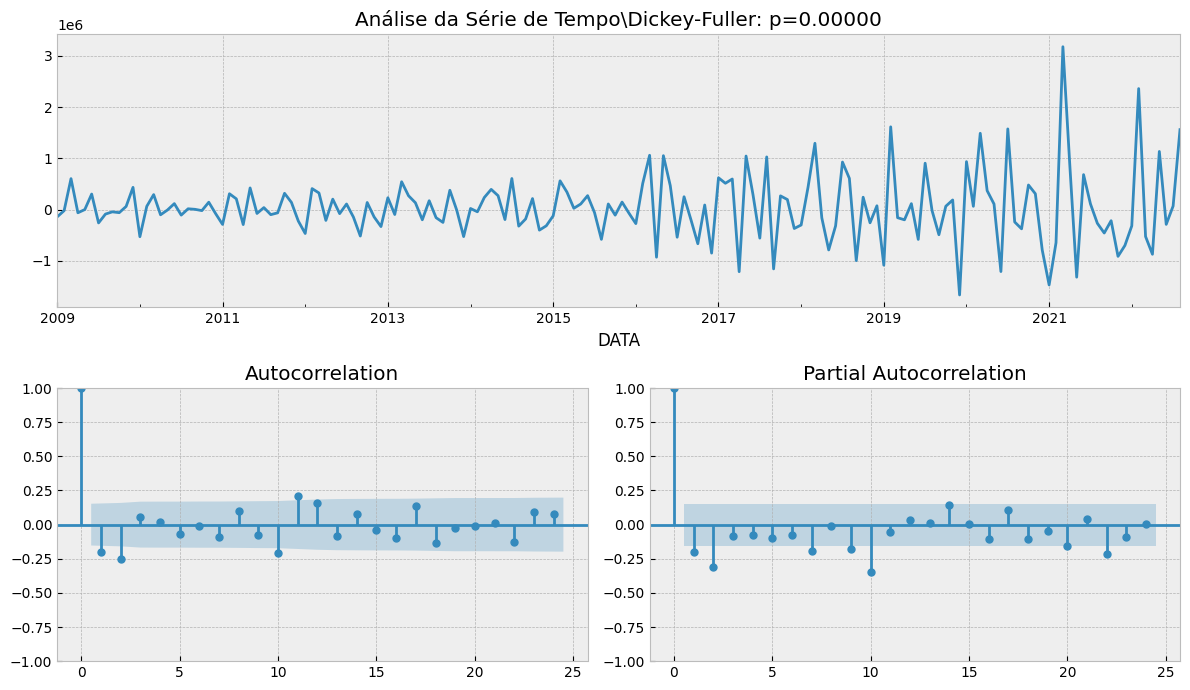

In [70]:
tsplot(df_vendas_ano.VALOR.diff().dropna(), lags = 24)

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série temporal com duas ordem de diferenciação.

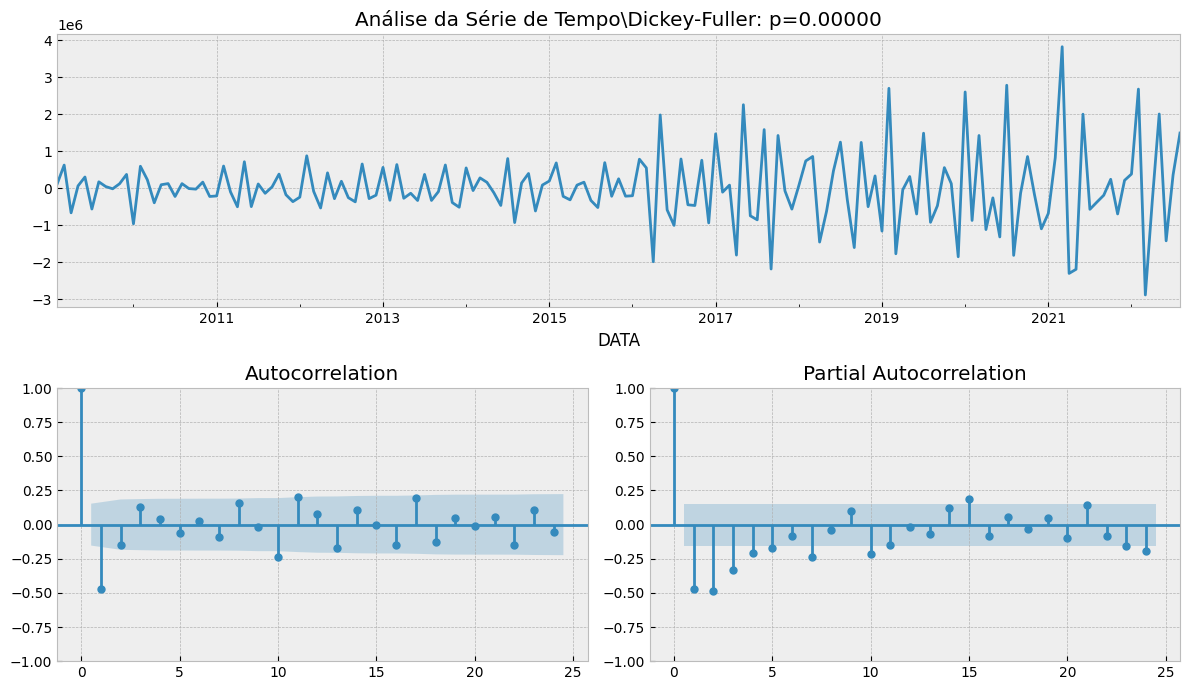

In [71]:
tsplot(df_vendas_ano.VALOR.diff().diff().dropna(), lags = 24)

Abaixo segue os teste do ARIMA com 4 combinações de parâmetros:
    #model_ARIMA_001: order 0, 0, 1
    model_ARIMA_002: order 0, 0, 2
    model_ARIMA_003: order 1, 1, 1
    model_ARIMA_004: order 1, 1, 2

Separando treino e teste para o modelo ARIMA

In [72]:
treino_ARIMA = df_vendas_ano['VALOR'].iloc[0:153]

Testando o modelo ARIMA com os valores 0,0,1 (model_ARIMA_001)

In [73]:
model_ARIMA_001 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(0, 0, 1))
results_ARIMA_001 = model_ARIMA_001.fit()
print(results_ARIMA_001.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2367.057
Date:                Wed, 26 Oct 2022   AIC                           4740.113
Time:                        13:18:18   BIC                           4749.205
Sample:                    12-01-2008   HQIC                          4743.807
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.837e+06   3.72e+05      7.632      0.000    2.11e+06    3.57e+06
ma.L1          0.7783      0.093      8.400      0.000       0.597       0.960
sigma2      2.796e+12      0.125   2.23e+13      0.0

Testando o modelo ARIMA com os valores 0,0,2 (model_ARIMA_002)

In [74]:
model_ARIMA_002 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(0, 0, 2))
results_ARIMA_002 = model_ARIMA_002.fit()
print(results_ARIMA_002.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -2354.392
Date:                Wed, 26 Oct 2022   AIC                           4716.785
Time:                        13:18:18   BIC                           4728.907
Sample:                    12-01-2008   HQIC                          4721.709
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.837e+06   6.44e+05      4.406      0.000    1.58e+06     4.1e+06
ma.L1          1.0742      0.261      4.113      0.000       0.562       1.586
ma.L2          0.5313      0.251      2.116      0.0

Testando o modelo ARIMA com os valores 1,1,1 (model_ARIMA_003)

In [75]:
model_ARIMA_003 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(1, 1, 1))
results_ARIMA_003  = model_ARIMA_003.fit()
print(results_ARIMA_003.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2225.634
Date:                Wed, 26 Oct 2022   AIC                           4457.267
Time:                        13:18:18   BIC                           4466.339
Sample:                    12-01-2008   HQIC                          4460.953
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3952      0.086      4.569      0.000       0.226       0.565
ma.L1         -0.7939      0.081     -9.853      0.000      -0.952      -0.636
sigma2      3.262e+11   1.75e-14   1.86e+25      0.0

Testando o modelo ARIMA com os valores 1,1,2 (model_ARIMA_004)

In [76]:
model_ARIMA_004 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(1, 1, 2))
results_ARIMA_004 = model_ARIMA_004.fit()

print(results_ARIMA_004.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2224.508
Date:                Wed, 26 Oct 2022   AIC                           4457.016
Time:                        13:18:18   BIC                           4469.111
Sample:                    12-01-2008   HQIC                          4461.929
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0494      0.244      0.202      0.840      -0.429       0.527
ma.L1         -0.4048      0.258     -1.566      0.117      -0.911       0.102
ma.L2         -0.2637      0.142     -1.857      0.0

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_002 (0,0,1)

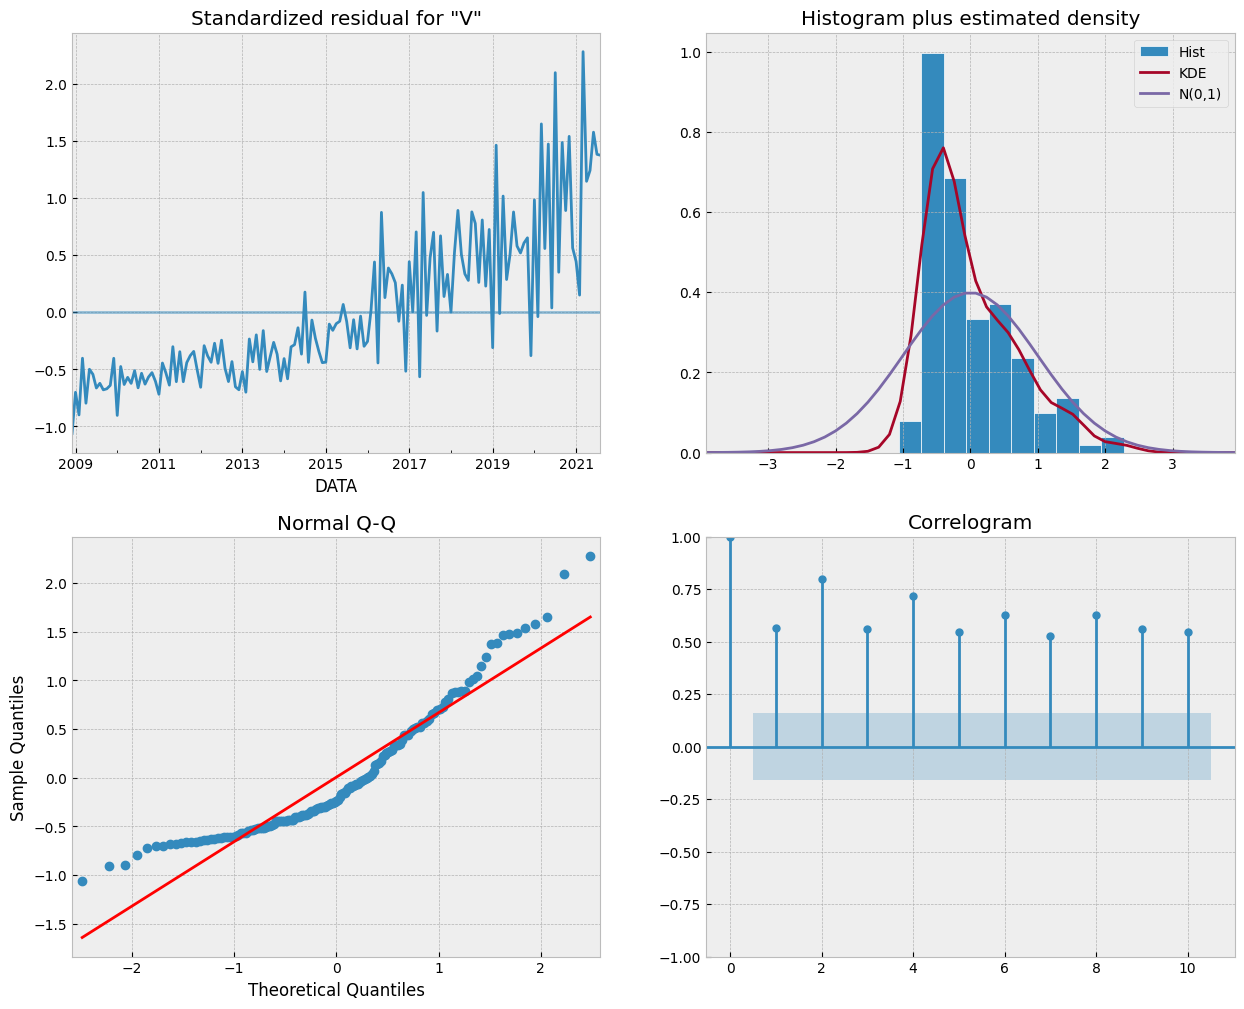

In [77]:
results_ARIMA_001.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_002 (0,0,2)

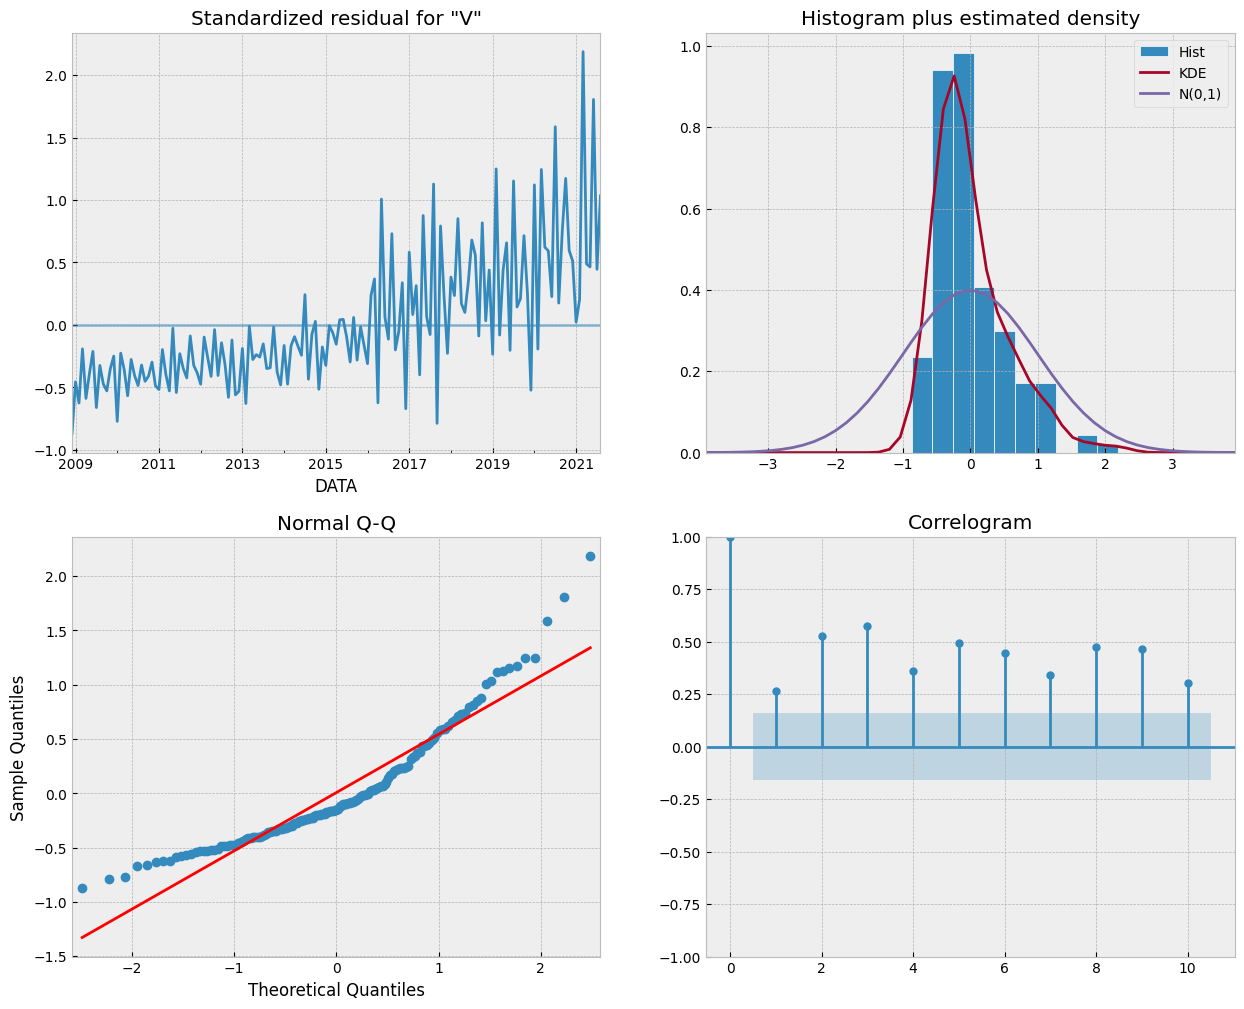

In [78]:
results_ARIMA_002.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_003 (1,1,1)

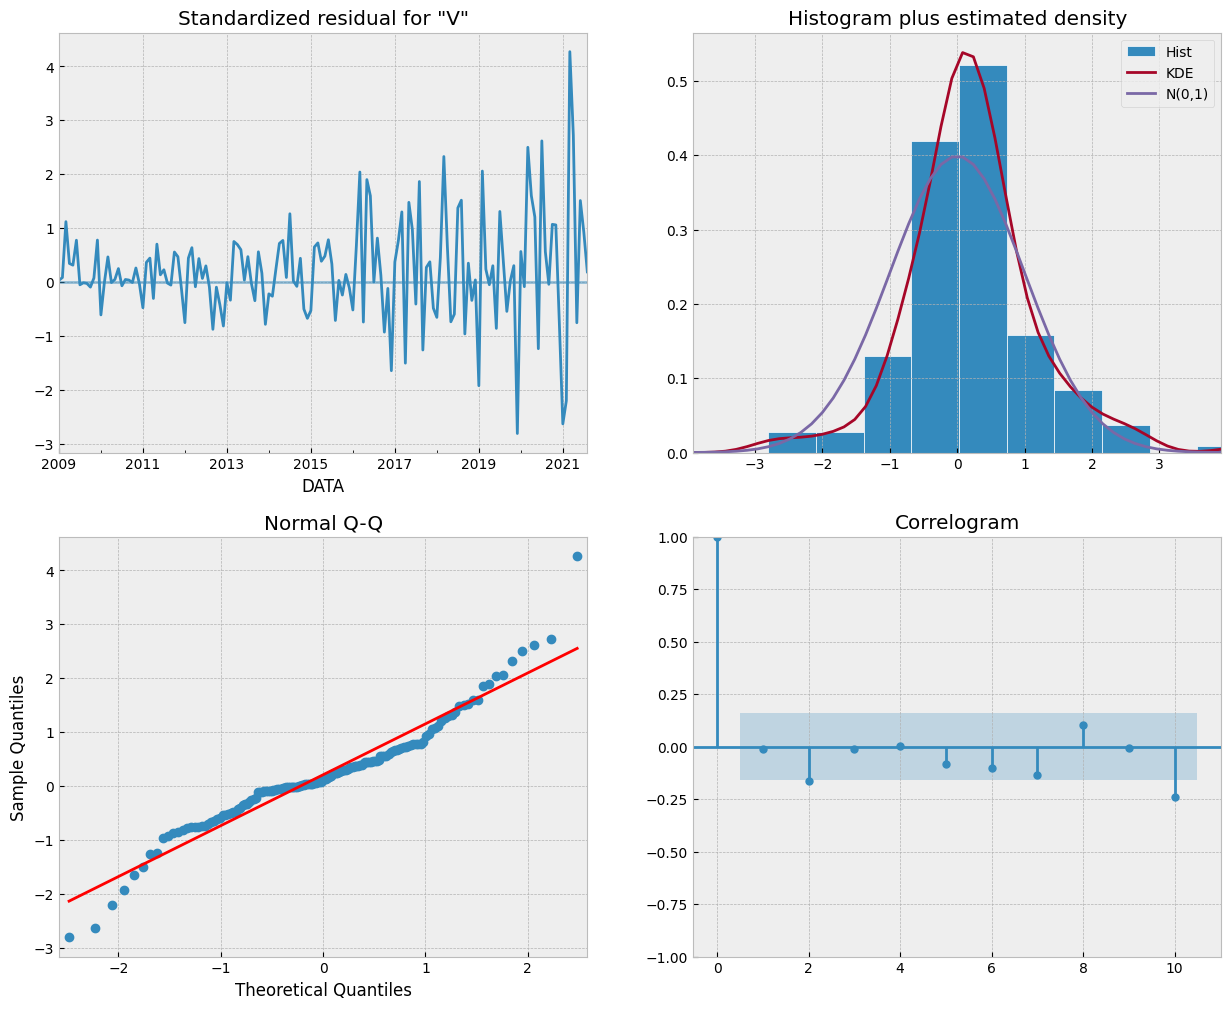

In [79]:
results_ARIMA_003.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_004 (1,1,2)

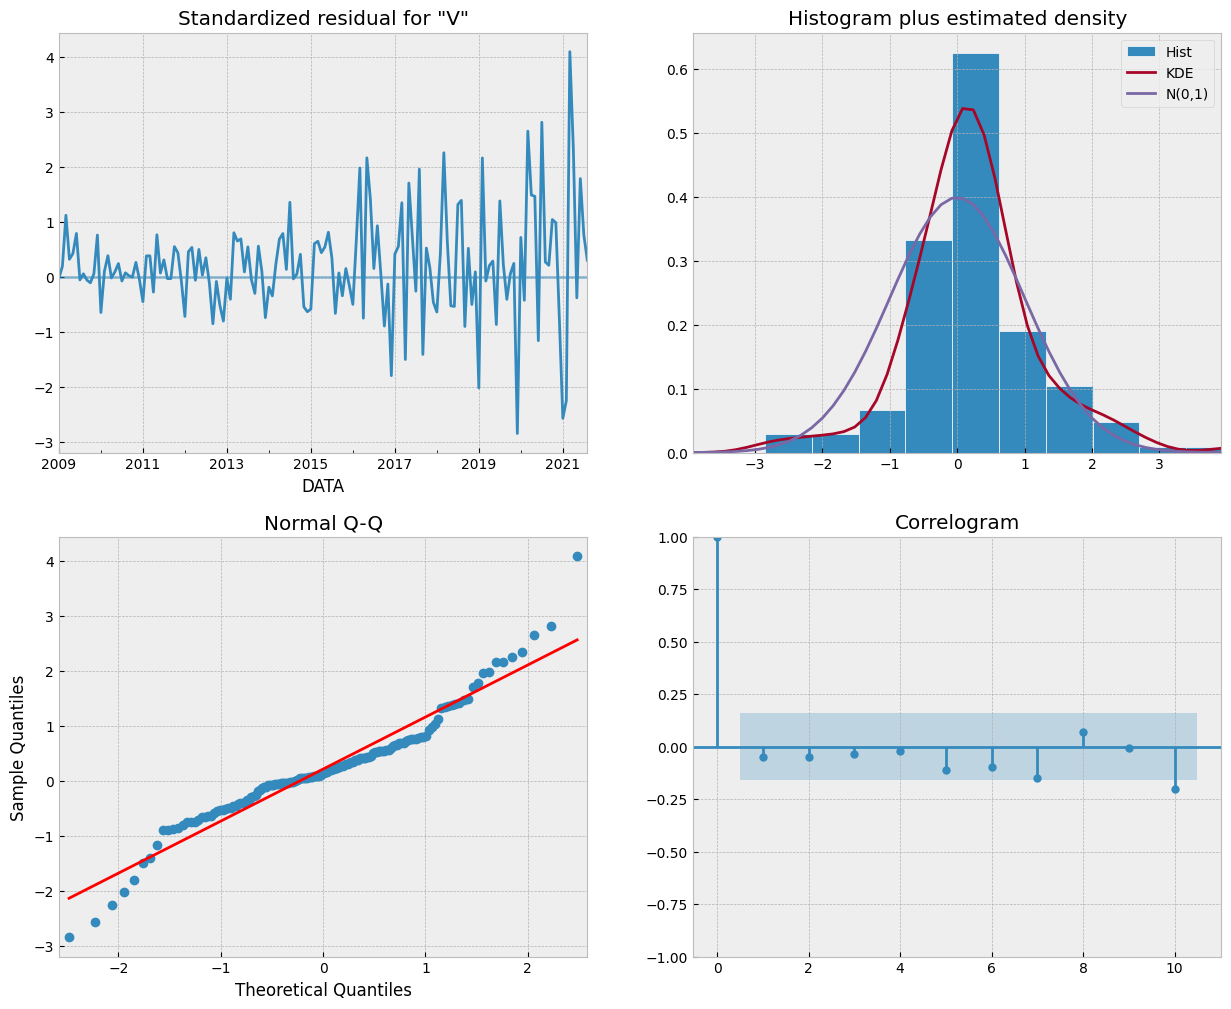

In [80]:
results_ARIMA_004.plot_diagnostics(figsize=(15, 12))
plt.show()

Verificamos pelos resultados que a configuração com ordem 1,1,2 os resultados parecem melhores

In [81]:
print("Resultado Modelo ARIMA 3 (1,1,1): ", results_ARIMA_003.fittedvalues)

Resultado Modelo ARIMA 3 (1,1,1):  DATA
2008-12-01                   0.00
2009-01-01             426,440.19
2009-02-01             376,762.96
2009-03-01             381,567.35
2009-04-01             771,951.19
                     ...         
2021-04-01           6,163,683.00
2021-05-01           6,830,160.90
2021-06-01           6,220,792.36
2021-07-01           6,668,840.24
2021-08-01           6,821,851.94
Freq: MS, Length: 153, dtype: float64


Observando as o modelo results_ARIMA_003 (1,1,1)

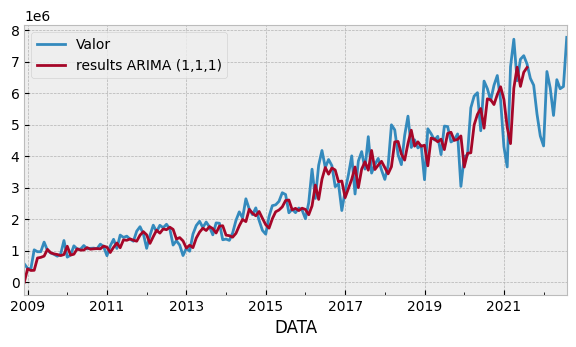

In [82]:
plt.figure(figsize = (7, 3.5))
df_vendas_ano['VALOR'].plot(label="Valor")
results_ARIMA_003.fittedvalues.plot(label="results ARIMA (1,1,1)");
plt.legend()

Adicionando colunas para armazenar os valores das diferenças com sazonalidade de 12 periodos

In [83]:
df_vendas_ano['VALOR First Difference'] = df_vendas_ano['VALOR'] - df_vendas_ano['VALOR'].shift(1)
df_vendas_ano['Seasonal First Difference']=df_vendas_ano['VALOR'] - df_vendas_ano['VALOR'].shift(12)

Comparação parâmetros teste adfuller serie original e com os valores de diferença de sazonalidade

In [84]:
print('Adfuller: ', adfuller_test(df_vendas_ano['VALOR']))
print('Adfuller Seasonal First Difference', adfuller_test(df_vendas_ano['Seasonal First Difference'].dropna()))

ADF Test Statistic : 0.7057957732261546
p-value : 0.9899528272545894
#Lags Used : 10
Number of Observations : 154
weak evidence against null hypothesis,indicating it is non-stationary 
Adfuller:  None
ADF Test Statistic : -2.8195487110211723
p-value : 0.0555351751723064
#Lags Used : 13
Number of Observations : 139
weak evidence against null hypothesis,indicating it is non-stationary 
Adfuller Seasonal First Difference None


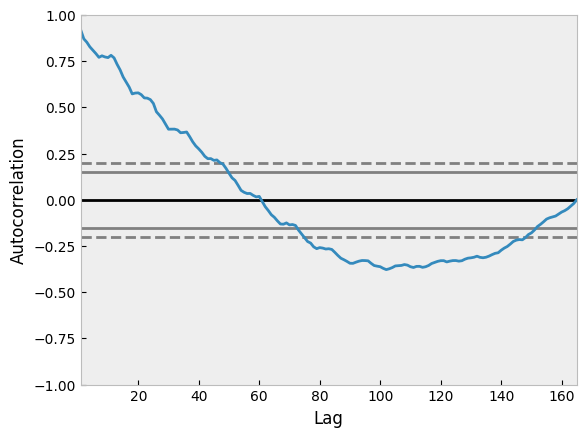

In [85]:
autocorrelation_plot(df_vendas_ano['VALOR'])
plt.show()

In [86]:
ARIMA_PREVISAO = results_ARIMA_003.predict(153, end = 164 ,dynamic=True)

Plot da previsão com modelo ARIMA que teve melhor desempenho 

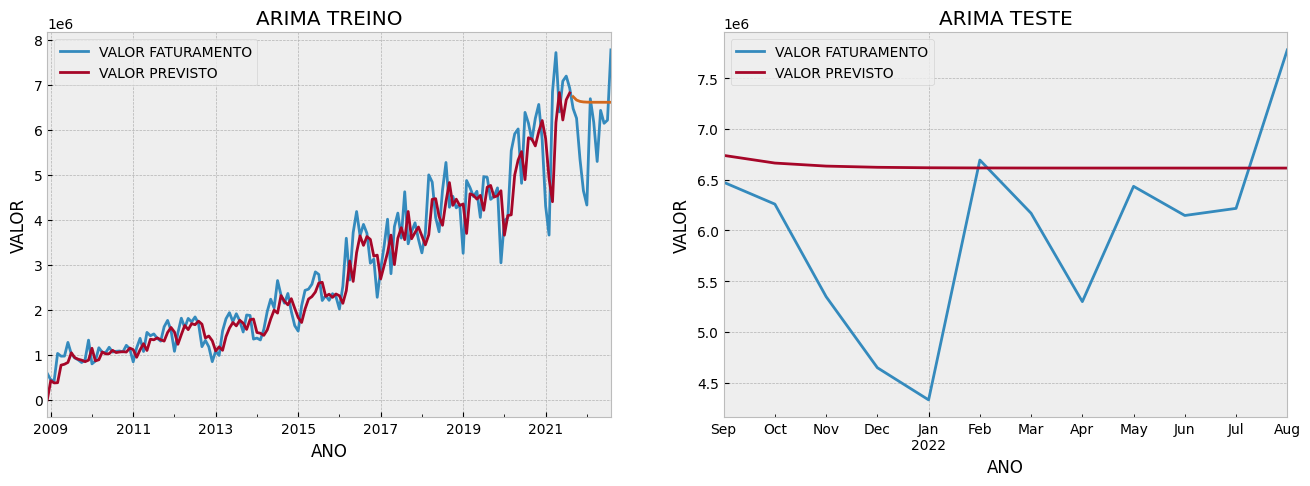

In [87]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
results_ARIMA_003.fittedvalues.plot(ax = axes[0]);
ARIMA_PREVISAO.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
ARIMA_PREVISAO.plot(ax = axes[1])
axes[0].set_title('ARIMA TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('ARIMA TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../ARIMA.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [88]:
Metricas_(ARIMA_PREVISAO, df_test['VALOR'], 'ARIMA')

(16.24, 855516.4750604569, 1107570.1776944723, 'ARIMA', 79577550.42)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [89]:
df_Results

Model                 RMSE                  MAE  \
7              Tendência Linear           869,372.88           729,726.87   
6          Tendendia Quadratica         1,246,642.42         1,008,080.03   
5     Transformação Logarítmica         1,633,104.44         1,414,324.86   
4           Simple Smoothing 03         1,198,540.18           957,294.34   
3           Simple Smoothing 05         1,334,673.92         1,119,321.77   
2           Simple Smoothing 08         1,340,795.37         1,126,227.43   
1  Triple Exponential Smoothing         1,389,749.14         1,168,133.52   
0                         ARIMA         1,107,570.18           855,516.48   

              MAPE (%)     Valor Anual (R$)  
7                12.69        70,070,915.48  
6                19.14        82,974,067.93  
5                26.30        88,768,133.84  
4                18.14        81,271,537.72  
3                21.06        83,604,732.71  
2                21.18        83,704,174.09  
1                21.75        84,681,636.74  
0                16.24        79,577,550.42

# 7 - SARIMA

Previsão com modelo SARIMA 

In [90]:
model_SARIMA=sm.tsa.statespace.SARIMAX(treino_ARIMA,order=(0, 1, 0),seasonal_order=(1,1,1,12))
results_SARIMA=model_SARIMA.fit()

Plot da previsão com modelo SARIMA

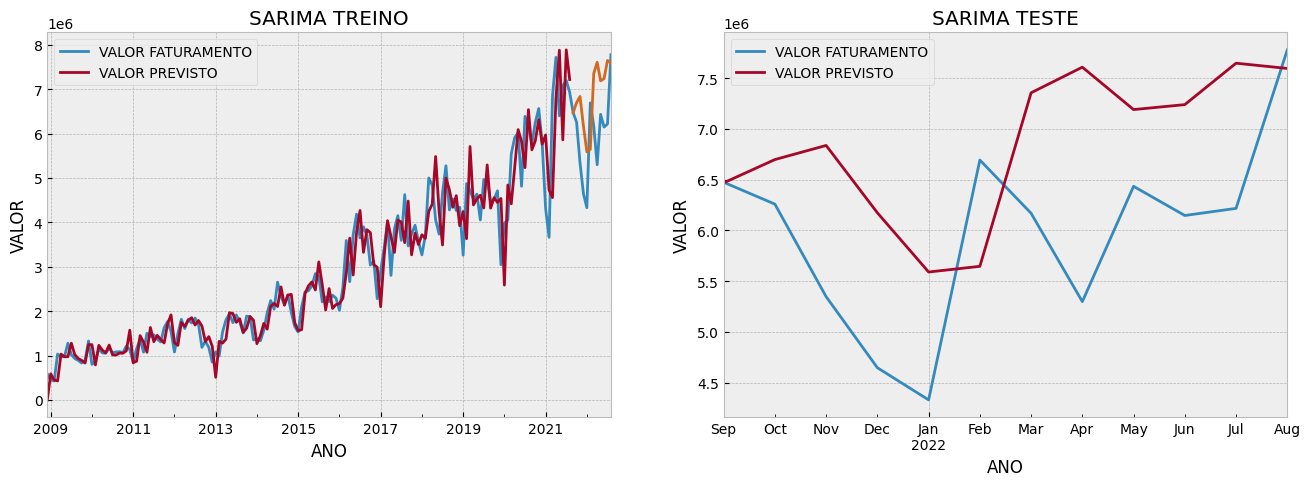

In [91]:
SARIMA_PREVISAO=results_SARIMA.predict(153, end = 164,dynamic=True)

fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
results_SARIMA.fittedvalues.plot(ax = axes[0]);
SARIMA_PREVISAO.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
SARIMA_PREVISAO.plot(ax = axes[1])
axes[0].set_title('SARIMA TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('SARIMA TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../SARIMA.png", dpi = 600 )

Criação de um novo dataframe para armazenar as previsões do modelo sarima

In [92]:
SARIMA_PREVISAO

2021-09-01           6,468,610.85
2021-10-01           6,698,116.25
2021-11-01           6,837,146.50
2021-12-01           6,173,812.75
2022-01-01           5,590,146.08
2022-02-01           5,646,132.66
2022-03-01           7,355,938.85
2022-04-01           7,608,500.52
2022-05-01           7,190,492.21
2022-06-01           7,239,499.08
2022-07-01           7,647,570.23
2022-08-01           7,595,893.03
Freq: MS, Name: predicted_mean, dtype: float64

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [93]:
Metricas_(SARIMA_PREVISAO, df_test['VALOR'], 'SARIMA')

(19.189999999999998,
 1060648.1788566457,
 1225348.7837844477,
 'SARIMA',
 82051858.99)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [94]:
df_Results

Model                 RMSE                  MAE  \
8              Tendência Linear           869,372.88           729,726.87   
7          Tendendia Quadratica         1,246,642.42         1,008,080.03   
6     Transformação Logarítmica         1,633,104.44         1,414,324.86   
5           Simple Smoothing 03         1,198,540.18           957,294.34   
4           Simple Smoothing 05         1,334,673.92         1,119,321.77   
3           Simple Smoothing 08         1,340,795.37         1,126,227.43   
2  Triple Exponential Smoothing         1,389,749.14         1,168,133.52   
1                         ARIMA         1,107,570.18           855,516.48   
0                        SARIMA         1,225,348.78         1,060,648.18   

              MAPE (%)     Valor Anual (R$)  
8                12.69        70,070,915.48  
7                19.14        82,974,067.93  
6                26.30        88,768,133.84  
5                18.14        81,271,537.72  
4                21.06        83,604,732.71  
3                21.18        83,704,174.09  
2                21.75        84,681,636.74  
1                16.24        79,577,550.42  
0                19.19        82,051,858.99

# 8 - Prophet

Criando um novo dataframe e definindo a coluna data como ds e a coluna target como y

In [95]:
df_prophet = pd.DataFrame({'ds':df_vendas_ano.index, 'y':df_vendas_ano.VALOR})

Fazendo um filtro para separar o treino do teste

In [96]:
filtro0 = df_prophet.index > '2021-08-01'
df_prophet_2022 = df_prophet.loc[filtro0]
filtro0 = df_prophet.index < '2021-09-01'
df_prophet_2021 = df_prophet.loc[filtro0]

validação_prophet é o nosso test para verificação do modelo

In [97]:
validação_prophet = pd.DatetimeIndex(df_prophet_2022['ds'],freq='MS')
validação_prophet
teste_prophet = pd.DatetimeIndex(df_prophet_2021['ds'],freq='MS')

Definindo a função RandomizedSearchCV para a pesquisa dos melhores parametros para o meu modelo Prophet

In [98]:
parametro = {
    'seasonality_mode':['multiplicative','additive'],
    'n_changepoints':[True,False],
    'changepoint_prior_scale': [0.01,0.015],
    'seasonality_prior_scale': [0.015,0.02],
    'yearly_seasonality':[True],
    'holidays_prior_scale':[0.1,0.5, 1, 5],
    'weekly_seasonality':[False],
    'daily_seasonality':[False]
}  
fh = validação_prophet


Utilizando a função ForecastingRandomizedSearchCV

In [99]:
cv = ExpandingWindowSplitter(
    initial_window=9,
    step_length=12,
    start_with_window=True,
    
)
forecaster = Prophet()
gscv = ForecastingRandomizedSearchCV(
    verbose = 1,
    n_jobs = -1,
    forecaster=forecaster,
    param_distributions=parametro,
    cv=cv)
prophet_treino = gscv.fit(df_prophet_2021['y'], fh=fh)
y_pred = gscv.predict(fh)

Fitting 12 folds for each of 10 candidates, totalling 120 fits


2022-10-26 13:18:34.791 WARNING prophet.models: Optimization terminated abnormally. Falling back to Newton.
2022-10-26 13:18:35.060 WARNING prophet.models: Optimization terminated abnormally. Falling back to Newton.


criando um dataframe com a previsão do treino

In [100]:
x_pred = gscv.predict(teste_prophet)

Olhando os melhores paramentros encontrados

In [101]:
print(gscv.best_params_)

{'yearly_seasonality': True, 'weekly_seasonality': False, 'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'n_changepoints': True, 'holidays_prior_scale': 1, 'daily_seasonality': False, 'changepoint_prior_scale': 0.01}


Verificando os valores preditos pelo modelo

In [102]:
y_pred

2021-09-01           5,529,685.40
2021-10-01           5,705,645.07
2021-11-01           5,817,015.42
2021-12-01           5,414,374.97
2022-01-01           5,210,046.77
2022-02-01           5,433,344.13
2022-03-01           6,242,892.14
2022-04-01           6,128,483.76
2022-05-01           6,072,525.02
2022-06-01           5,974,448.15
2022-07-01           6,318,761.58
2022-08-01           6,395,056.38
dtype: float64

Plotando no grafico o valor real em azul e a previsão em vermelho

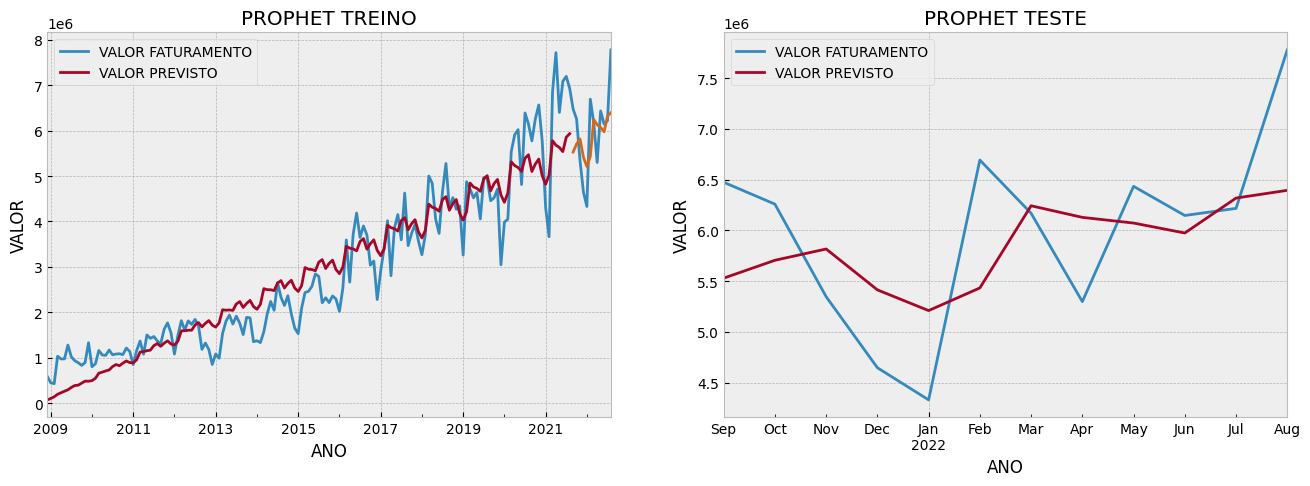

In [103]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
x_pred.plot(ax = axes[0])
y_pred.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
y_pred.plot(ax = axes[1])
axes[0].set_title('PROPHET TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('PROPHET TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../PROPHET.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [104]:
Metricas_(y_pred, df_test['VALOR'], 'Prophet')

(11.05, 649893.9429114672, 771914.4972156828, 'Prophet', 70242278.77)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [105]:
df_Results

Model                 RMSE                  MAE  \
9              Tendência Linear           869,372.88           729,726.87   
8          Tendendia Quadratica         1,246,642.42         1,008,080.03   
7     Transformação Logarítmica         1,633,104.44         1,414,324.86   
6           Simple Smoothing 03         1,198,540.18           957,294.34   
5           Simple Smoothing 05         1,334,673.92         1,119,321.77   
4           Simple Smoothing 08         1,340,795.37         1,126,227.43   
3  Triple Exponential Smoothing         1,389,749.14         1,168,133.52   
2                         ARIMA         1,107,570.18           855,516.48   
1                        SARIMA         1,225,348.78         1,060,648.18   
0                       Prophet           771,914.50           649,893.94   

              MAPE (%)     Valor Anual (R$)  
9                12.69        70,070,915.48  
8                19.14        82,974,067.93  
7                26.30        88,768,133.84  
6                18.14        81,271,537.72  
5                21.06        83,604,732.71  
4                21.18        83,704,174.09  
3                21.75        84,681,636.74  
2                16.24        79,577,550.42  
1                19.19        82,051,858.99  
0                11.05        70,242,278.77

Serializando o modelo Prophet

In [106]:
with open('modelo_prophet.pkl', 'wb') as file:
    pickle.dump(prophet_treino, file)

Para utilizar o modelo xgboost já treinado você pode carregar o modelo pkl com o comando:

with open('modelo_xgboost.pkl', 'rb') as f:
    modelo_xgboost = pickle.load(f)

# 9 - Xgboost

Definindo um novo dataframe para o modelo XGBoost e deixando somente a coluna valor

In [107]:
df_xgboost = pd.DataFrame({'Datetime':df_vendas_ano.index, 'VALOR':df_vendas_ano.VALOR})
df_xgboost.drop('Datetime', axis = 1, inplace = True)

Separando meu conjunto de treino, validação e test

In [108]:
end_train = '2021-08-01'
end_validation = '2022-08-01'
data_train = df_xgboost.loc[: end_train, :]
data_val   = df_xgboost.loc[end_train:end_validation, :]
data_test  = df_xgboost.loc[end_validation:, :]
dxg_train, dxg_test = train_test_split(df_xgboost, test_size = 12, random_state = 42, shuffle = False)

Plot do meu dados de treino e de test

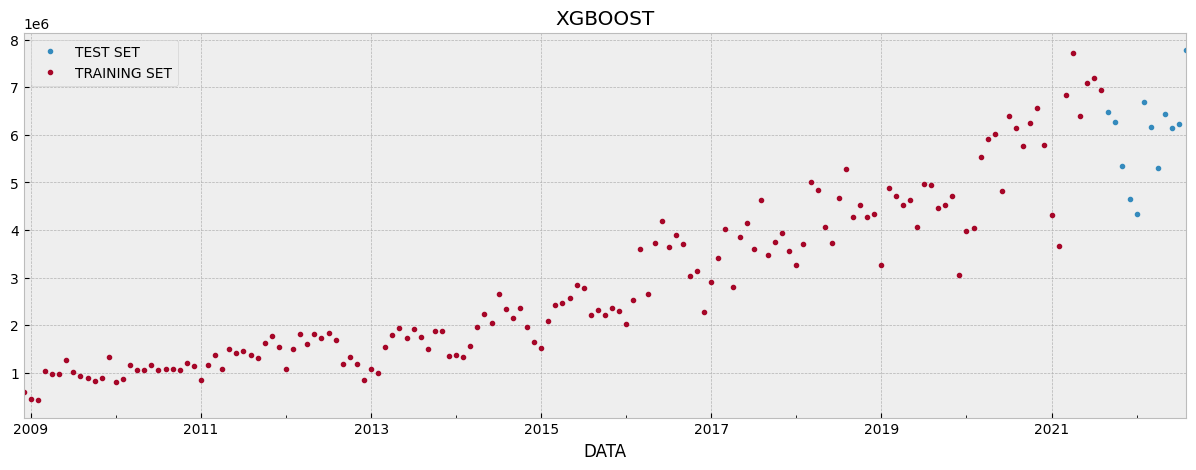

In [109]:
_ = dxg_test \
    .rename(columns={'VALOR': 'TEST SET'}) \
    .join(dxg_train.rename(columns={'VALOR': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='XGBOOST', style='.')

Função que cria mais features baseados em epocas

In [110]:
def create_features(df_xgboost, label=None):
    df_xgboost['date'] = df_xgboost.index
    df_xgboost['dayofweek'] = df_xgboost['date'].dt.dayofweek
    df_xgboost['quarter'] = df_xgboost['date'].dt.quarter
    df_xgboost['month'] = df_xgboost['date'].dt.month
    df_xgboost['year'] = df_xgboost['date'].dt.year
    df_xgboost['dayofyear'] = df_xgboost['date'].dt.dayofyear
    df_xgboost['dayofmonth'] = df_xgboost['date'].dt.day
    df_xgboost['weekofyear'] = df_xgboost['date'].dt.weekofyear
    
    X = df_xgboost[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_xgboost[label]
        return X, y
    return X

In [111]:
dxgb_train, dygb_train = create_features(dxg_train, label='VALOR')
dxgb_test, dygb_test = create_features(dxg_test, label='VALOR')

Trazendos os melhores paramentros encontrados

In [112]:
forecaster  =  ForecasterAutoreg ( 
                regressor  =  XGBRegressor ( random_state = 42 ), 
                lags  =  153 
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58

Aplicandos os paramentros e executando o Grid Search

In [113]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_depth': [5,6,7,8],
    'learning_rate': [0.015,0.02,0.022]
    }

lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = df_xgboost.loc[:end_validation, 'VALOR'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 12,
        refit              = False,
        metric             = 'mean_absolute_percentage_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        #fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 144.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:27<00:00,  6.98s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 200}
  Backtesting metric: 0.06702767000605851



Colocandos os melhores Hyperparamentros encontrados, mas foi alterado o max_depth para 6 devido a baixa variação nos erros, assim fazendo com que o modelo tivesse ganho em desempenho.

In [114]:
reg = xgb.XGBRegressor(n_estimators=200, max_depth = 6, learning_rate = 0.022)
model_xgboost = reg.fit(dxgb_train, dygb_train,
                eval_set=[(dxgb_train, dygb_train), (dxgb_test, dygb_test)],
                early_stopping_rounds=30,
                verbose=False)


Plot das features mais importantes

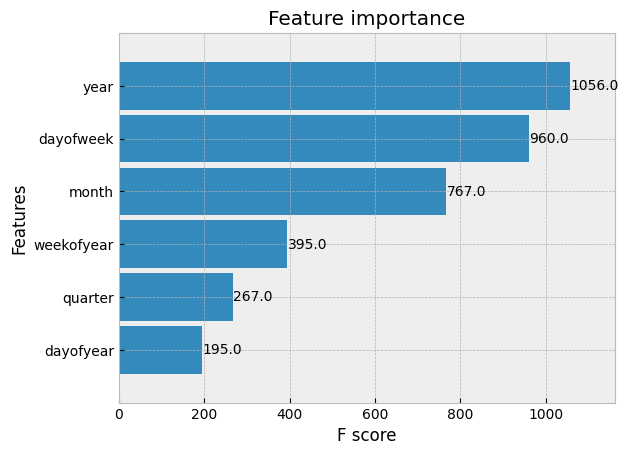

In [115]:
_ = plot_importance(reg, height=0.9)

fazendo o predict do modelo e mostrandos os valores

In [116]:
dxg_test['XGB_Prediction'] = model_xgboost.predict(dxgb_test)
dxg_train['XGB_Train'] = model_xgboost.predict(dxgb_train)
xgboost = dxg_test['XGB_Prediction']

Plot da previsão do modelo e do valor real

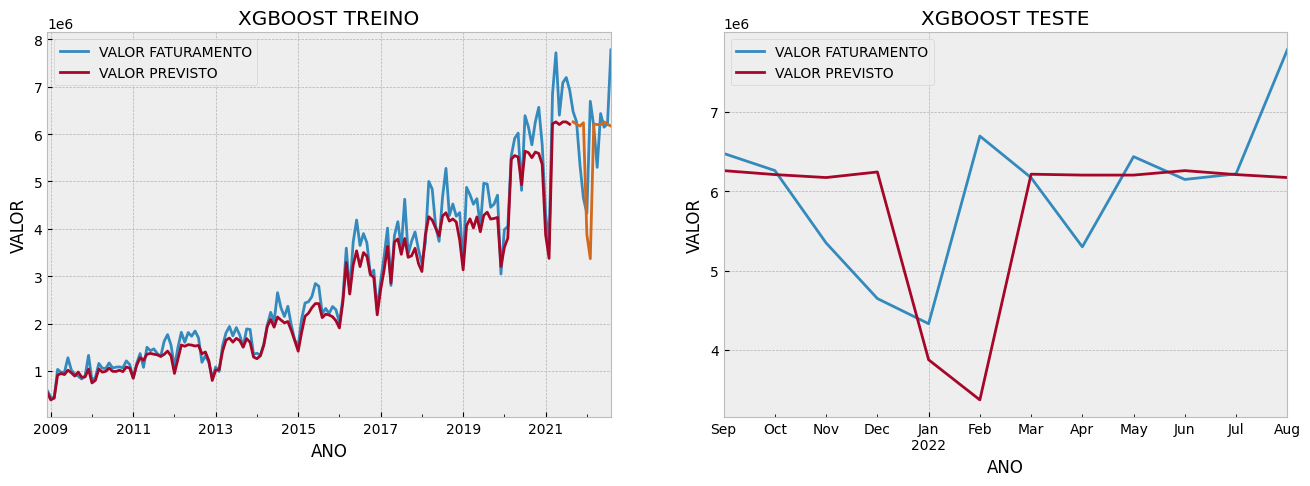

In [117]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
dxg_train['XGB_Train'].plot(ax = axes[0])
xgboost.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
xgboost.plot(ax = axes[1])
axes[0].set_title('XGBOOST TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('XGBOOST TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../XGBOOST.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [118]:
Metricas_(dxg_test['XGB_Prediction'], df_test['VALOR'], 'XGBoost')

(13.170000000000002,
 780785.9533333331,
 1224219.1856004016,
 'XGBoost',
 69379730.0)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [119]:
df_Results

Model                 RMSE                  MAE  \
10              Tendência Linear           869,372.88           729,726.87   
9           Tendendia Quadratica         1,246,642.42         1,008,080.03   
8      Transformação Logarítmica         1,633,104.44         1,414,324.86   
7            Simple Smoothing 03         1,198,540.18           957,294.34   
6            Simple Smoothing 05         1,334,673.92         1,119,321.77   
5            Simple Smoothing 08         1,340,795.37         1,126,227.43   
4   Triple Exponential Smoothing         1,389,749.14         1,168,133.52   
3                          ARIMA         1,107,570.18           855,516.48   
2                         SARIMA         1,225,348.78         1,060,648.18   
1                        Prophet           771,914.50           649,893.94   
0                        XGBoost         1,224,219.19           780,785.95   

               MAPE (%)     Valor Anual (R$)  
10                12.69        70,070,915.48  
9                 19.14        82,974,067.93  
8                 26.30        88,768,133.84  
7                 18.14        81,271,537.72  
6                 21.06        83,604,732.71  
5                 21.18        83,704,174.09  
4                 21.75        84,681,636.74  
3                 16.24        79,577,550.42  
2                 19.19        82,051,858.99  
1                 11.05        70,242,278.77  
0                 13.17        69,379,728.00

# 10 - LSTM Rede Neural Recorrente

Criando o dataframe para o modelo LSTM

In [120]:
df_LSTM = df_prophet.drop('ds',axis=1)

Aplicando um filtro considerando as datas a partir de 2009/09/01 para afim de termos ciclos de 12 meses

In [121]:
filtro1 = df_LSTM.index >= '2009-09-01'
filtro1
df_LSTM_2011 = df_LSTM.loc[filtro1]
df_LSTM_2011.index

DatetimeIndex(['2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01',
               ...
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', name='DATA', length=156, freq='MS')

Vamos agora separar os dados de treino e teste

In [122]:
data=df_LSTM_2011.filter(['y'])
dataset=data.values
training_data_len=math.ceil(len(dataset)-12)
training_data_len_2=math.ceil(len(dataset))

Alterando a escala dos dados de 0 a 1

In [123]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

Separando as bases de treino e teste

Separando o treino para verificar a quantidade de epocas pelo gráfico

In [124]:
train_data_2 = scaled_data[0:training_data_len_2,:]
x_train_2=[]
y_train_2=[]

for i in range(12,len(train_data_2)):
  x_train_2.append(train_data_2[i-12:i,0])
  y_train_2.append(train_data_2[i,0])
  if i<=12:
    print(x_train_2)
    print(y_train_2)
    print()

[array([0.01279164, 0.00436088, 0.01330593, 0.07566114, 0.        ,
       0.00932859, 0.05142412, 0.03704883, 0.03604373, 0.05288837,
       0.03766452, 0.04008683])]
[0.041019005336015435]



convertendo x_train e y_train para um array numpy

In [125]:
x_train_2,y_train_2 = np.array(x_train_2), np.array(y_train_2)

Redimensionamento dos dados

In [126]:
x_train_2=np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1],1))

Criando a base de teste

In [127]:
test_data=scaled_data[training_data_len-12:,:]
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(12,len(test_data)):
  x_test.append(test_data[i-12:i,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Criando o modelo de rede neural com 3 camadas

In [128]:
model=Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(x_train_2.shape[1],1)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compilando o modelo

In [129]:
model.compile(optimizer=Adam(learning_rate=0.005), loss = 'mean_absolute_error', metrics = [RootMeanSquaredError()])

Epoch 1/100
6/6 [==============================] - 4s 178ms/step - loss: 0.2169 - root_mean_squared_error: 0.2914 - val_loss: 0.1332 - val_root_mean_squared_error: 0.1579
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1620 - root_mean_squared_error: 0.1897 - val_loss: 0.3132 - val_root_mean_squared_error: 0.3401
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1381 - root_mean_squared_error: 0.1885 - val_loss: 0.1083 - val_root_mean_squared_error: 0.1360
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0721 - root_mean_squared_error: 0.0954 - val_loss: 0.1907 - val_root_mean_squared_error: 0.2184
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0718 - root_mean_squared_error: 0.0973 - val_loss: 0.1317 - val_root_mean_squared_error: 0.1702
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0716 - root_mean_squared_error: 0.0962 - val_loss: 0.1503 - val_root_mean_s

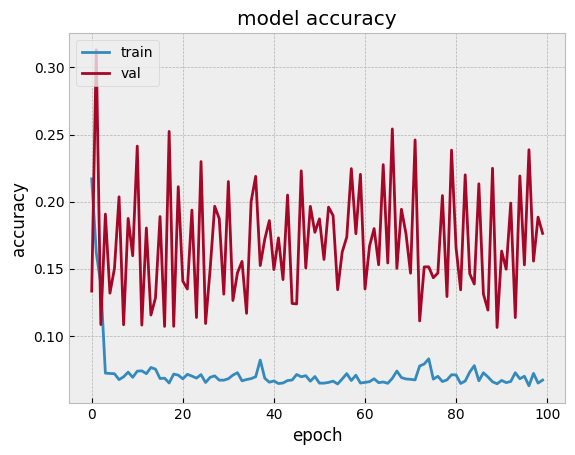

In [130]:
history = model.fit(x_train_2, y_train_2,validation_split=0.0833 , epochs=100, batch_size=24)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [131]:
model.compile(optimizer=Adam(learning_rate=0.005), loss = 'mean_absolute_error', metrics = [RootMeanSquaredError()])

Fazendo o fit do modelo e foram escolhidos 20 epocas baseado no plot anterior

In [132]:
model.fit(x_train_2,x_train_2,batch_size=24,epochs=60)

Epoch 1/60
6/6 [==============================] - 3s 7ms/step - loss: 0.0746 - root_mean_squared_error: 0.1028
Epoch 2/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0655 - root_mean_squared_error: 0.0901
Epoch 3/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0641 - root_mean_squared_error: 0.0891
Epoch 4/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0608 - root_mean_squared_error: 0.0884
Epoch 5/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0599 - root_mean_squared_error: 0.0847
Epoch 6/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0600 - root_mean_squared_error: 0.0870
Epoch 7/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0599 - root_mean_squared_error: 0.0855
Epoch 8/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0596 - root_mean_squared_error: 0.0853
Epoch 9/60
6/6 [==============================] - 0s 6ms/step - loss: 0.0594 - root_mean_squared_error: 0.0858
E

In [133]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 12, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 25)                275       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,461
Trainable params: 2,461
Non-trainable params: 0
_________________________________________________________________


Gerando as previsões, invertendo a escala e mostrando os valores

In [134]:
treino_pred = model.predict(x_train_2)
treino_pred = scaler.inverse_transform(treino_pred)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


predictions

1/1 [==============================] - 0s 15ms/step


array([[6465066. ],
       [6563177. ],
       [6596186. ],
       [6546701.5],
       [6497691. ],
       [6510835.5],
       [6649554.5],
       [6563450.5],
       [6376674.5],
       [6338765. ],
       [6252745. ],
       [6166846. ]], dtype=float32)

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [135]:
Metricas_(predictions, y_test, 'LSTM')

(14.92, 787885.1508333333, 1097832.2800954378, 'LSTM', 77527700.0)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [136]:
df_Results

Model                 RMSE                  MAE  \
11              Tendência Linear           869,372.88           729,726.87   
10          Tendendia Quadratica         1,246,642.42         1,008,080.03   
9      Transformação Logarítmica         1,633,104.44         1,414,324.86   
8            Simple Smoothing 03         1,198,540.18           957,294.34   
7            Simple Smoothing 05         1,334,673.92         1,119,321.77   
6            Simple Smoothing 08         1,340,795.37         1,126,227.43   
5   Triple Exponential Smoothing         1,389,749.14         1,168,133.52   
4                          ARIMA         1,107,570.18           855,516.48   
3                         SARIMA         1,225,348.78         1,060,648.18   
2                        Prophet           771,914.50           649,893.94   
1                        XGBoost         1,224,219.19           780,785.95   
0                           LSTM         1,097,832.28           787,885.15   

               MAPE (%)     Valor Anual (R$)  
11                12.69        70,070,915.48  
10                19.14        82,974,067.93  
9                 26.30        88,768,133.84  
8                 18.14        81,271,537.72  
7                 21.06        83,604,732.71  
6                 21.18        83,704,174.09  
5                 21.75        84,681,636.74  
4                 16.24        79,577,550.42  
3                 19.19        82,051,858.99  
2                 11.05        70,242,278.77  
1                 13.17        69,379,728.00  
0                 14.92        77,527,696.00

Separando os dados para plotagem

In [137]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions'] = predictions
train['Predictions'] = treino_pred

Plotando a previsão de faturamento e o valor real

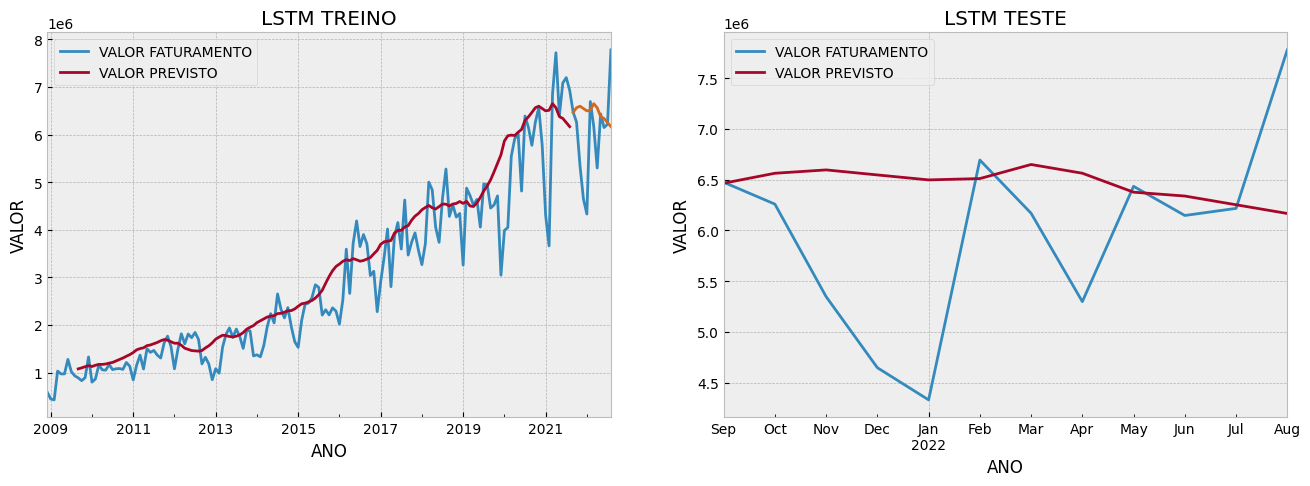

In [138]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
train['Predictions'].plot(ax = axes[0])
valid['Predictions'].plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
valid['Predictions'].plot(ax = axes[1])
axes[0].set_title('LSTM TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('LSTM TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../LSTM.png", dpi = 600 )

# 11 ENSEMBLE

Criação do dataframe Ensemble com a combinação dos resultados de todos os modelos.

In [139]:
df_ensemble = df_test.drop(columns=['DATAINDEX', 'DATAINDEX_SQ','LOG_VALOR', 'LOG_TREND'])

Adicionando os resultados dos modelos no dataframe

In [140]:
df_ensemble = pd.concat([df_ensemble, df_linear], axis=1)
df_ensemble.rename(columns={0: 'Tendência Linear'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, SARIMA_PREVISAO], axis=1)
df_ensemble.rename(columns={'predicted_mean':'Sarima'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, y_pred], axis=1)
df_ensemble.rename(columns={0:'Prophet'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, predictions_hw], axis=1)
df_ensemble.rename(columns={'HW':'Tri Exp Smoothing'}, inplace=True)
df_ensemble.rename(columns={'QUADRATIC_TEND':'Tend Quadrática'}, inplace=True)
df_ensemble.rename(columns={'BACK_LOG_TREND':'Trans Logarítmica'}, inplace=True)
df_ensemble['LSTM'] = predictions
df_ensemble['XGBoost'] = xgboost
df_ensemble

VALOR      Tend Quadrática    Trans Logarítmica  \
2021-09-01         6,474,583.00         6,517,932.11         6,840,480.23   
2021-10-01         6,258,976.46         6,588,563.69         6,937,037.47   
2021-11-01         5,347,073.57         6,659,637.07         7,034,957.67   
2021-12-01         4,647,181.89         6,731,152.27         7,134,260.07   
2022-01-01         4,330,274.92         6,803,109.28         7,234,964.18   
2022-02-01         6,693,387.77         6,875,508.10         7,337,089.79   
2022-03-01         6,169,128.71         6,948,348.74         7,440,656.95   
2022-04-01         5,298,393.94         7,021,631.18         7,545,686.03   
2022-05-01         6,434,290.54         7,095,355.45         7,652,197.65   
2022-06-01         6,147,065.29         7,169,521.52         7,760,212.74   
2022-07-01         6,217,136.31         7,244,129.41         7,869,752.52   
2022-08-01         7,778,743.09         7,319,179.11         7,980,838.52   

            Simple Smoothing 03  Simple Smoothing 05  Simple Smoothing 08  \
2021-09-01         6,772,628.14         6,967,061.06         6,975,347.84   
2021-10-01         6,772,628.14         6,967,061.06         6,975,347.84   
2021-11-01         6,772,628.14         6,967,061.06         6,975,347.84   
2021-12-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-01-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-02-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-03-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-04-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-05-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-06-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-07-01         6,772,628.14         6,967,061.06         6,975,347.84   
2022-08-01         6,772,628.14         6,967,061.06         6,975,347.84   

               Tendência Linear               Sarima              Prophet  \
2021-09-01         5,639,092.16         6,468,610.85         5,529,685.40   
2021-10-01         5,675,483.22         6,698,116.25         5,705,645.07   
2021-11-01         5,711,874.27         6,837,146.50         5,817,015.42   
2021-12-01         5,748,265.32         6,173,812.75         5,414,374.97   
2022-01-01         5,784,656.38         5,590,146.08         5,210,046.77   
2022-02-01         5,821,047.43         5,646,132.66         5,433,344.13   
2022-03-01         5,857,438.48         7,355,938.85         6,242,892.14   
2022-04-01         5,893,829.54         7,608,500.52         6,128,483.76   
2022-05-01         5,930,220.59         7,190,492.21         6,072,525.02   
2022-06-01         5,966,611.64         7,239,499.08         5,974,448.15   
2022-07-01         6,003,002.70         7,647,570.23         6,318,761.58   
2022-08-01         6,039,393.75         7,595,893.03         6,395,056.38   

              Tri Exp Smoothing                 LSTM              XGBoost  
2021-09-01         6,920,446.02         6,465,066.00         6,258,032.50  
2021-10-01         7,188,506.71         6,563,177.00         6,208,336.00  
2021-11-01         7,628,603.70         6,596,186.00         6,170,937.00  
2021-12-01         6,442,453.50         6,546,701.50         6,241,181.50  
2022-01-01         6,959,497.09         6,497,691.00         3,875,975.00  
2022-02-01         7,372,087.29         6,510,835.50         3,370,839.75  
2022-03-01         7,659,075.26         6,649,554.50         6,213,188.00  
2022-04-01         6,944,885.21         6,563,450.50         6,201,968.50  
2022-05-01         7,364,113.92         6,376,674.50         6,201,968.50  
2022-06-01         6,480,653.92         6,338,765.00         6,258,032.50  
2022-07-01         6,508,671.52         6,252,745.00         6,208,336.00  
2022-08-01         7,212,642.61         6,166,846.00         6,170,937.00

Escolhendo os modelos que tiveram os melhores resultados e agrupando pela média.

In [141]:
df_ensemble["Ensemble"] = df_ensemble[['Tendência Linear','LSTM','Simple Smoothing 08','Trans Logarítmica','Prophet','XGBoost']].mean(axis=1)

Plot do modelo ensemble

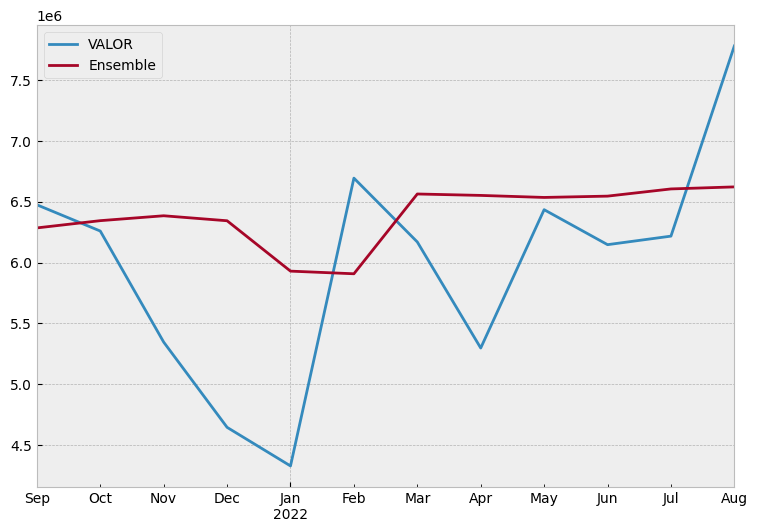

In [142]:
df_ensemble.VALOR.plot(figsize = (9,6), legend = True)
df_ensemble.Ensemble.plot(legend = True)
#plt.savefig("Ensemble.pdf")
plt.show()

Criando um ensemble dos modelos de treino

In [143]:
df_ensemble_train = df_train.drop(columns=['DATAINDEX', 'DATAINDEX_SQ','LOG_VALOR', 'LOG_TREND'])
df_ensemble_train = pd.concat([df_ensemble_train, df_linear_train], axis=1)
df_ensemble_train.rename(columns={0: 'Tendência Linear'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, model_exp_smoothing_08.fittedvalues], axis=1)
df_ensemble_train.rename(columns={0:'Simple Smoothing 08'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, treino_hw], axis=1)
df_ensemble_train.rename(columns={0:'Triple Exp Smoothing'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, results_ARIMA_003.fittedvalues], axis=1)
df_ensemble_train.rename(columns={0:'ARIMA'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, results_SARIMA.fittedvalues], axis=1)
df_ensemble_train.rename(columns={0:'SARIMA'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, x_pred], axis=1)
df_ensemble_train.rename(columns={0:'Prophet'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, dxg_train['XGB_Train']], axis=1)
df_ensemble_train = pd.concat([df_ensemble_train, train['Predictions']], axis=1)
df_ensemble_train.rename(columns={'LinearTrend':'Tendência Linear'}, inplace=True)
df_ensemble_train.rename(columns={'XGB_Train':'XGBoost'}, inplace=True)
df_ensemble_train.rename(columns={'Predictions':'LSTM'}, inplace=True)
df_ensemble_train.rename(columns={'QUADRATIC_TEND':'Tend Quadrática'}, inplace=True)
df_ensemble_train.rename(columns={'BACK_LOG_TREND':'Trans Logarítmica'}, inplace=True)
df_ensemble_train

VALOR      Tend Quadrática    Trans Logarítmica  \
2008-12-01           586,451.99           916,302.28           801,137.38   
2009-01-01           446,576.62           919,336.44           812,445.89   
2009-02-01           427,042.93           922,812.42           823,914.02   
2009-03-01         1,032,328.70           926,730.21           835,544.04   
2009-04-01           971,640.59           931,089.81           847,338.21   
...                         ...                  ...                  ...   
2021-04-01         7,718,497.40         6,171,401.46         6,377,483.60   
2021-05-01         6,400,604.19         6,239,823.96         6,467,505.38   
2021-06-01         7,084,102.26         6,308,688.28         6,558,797.87   
2021-07-01         7,196,237.52         6,377,994.41         6,651,379.01   
2021-08-01         6,930,520.54         6,447,742.36         6,745,266.98   

               Tendência Linear  Simple Smoothing 08  Triple Exp Smoothing  \
2008-12-01            71,261.04           586,451.99          1,108,012.08   
2009-01-01           107,652.09           586,451.99            827,646.34   
2009-02-01           144,043.14           474,551.69            750,703.83   
2009-03-01           180,434.19           436,544.68            632,911.00   
2009-04-01           216,825.25           913,171.90            838,469.47   
...                         ...                  ...                   ...   
2021-04-01         5,457,136.90         6,245,594.42          5,414,965.44   
2021-05-01         5,493,527.95         7,423,916.80          7,244,805.95   
2021-06-01         5,529,919.00         6,605,266.71          6,545,692.91   
2021-07-01         5,566,310.06         6,988,335.15          6,079,933.05   
2021-08-01         5,602,701.11         7,154,657.05          7,056,141.80   

                          ARIMA               SARIMA              Prophet  \
2008-12-01                 0.00                 0.00            70,256.64   
2009-01-01           426,440.19           586,451.99           100,489.65   
2009-02-01           376,762.96           446,576.62           138,544.63   
2009-03-01           381,567.35           427,042.93           194,106.68   
2009-04-01           771,951.19         1,032,328.70           228,074.88   
...                         ...                  ...                  ...   
2021-04-01         6,163,683.00         6,794,087.89         5,680,024.21   
2021-05-01         6,830,160.90         7,879,578.96         5,629,952.55   
2021-06-01         6,220,792.36         5,859,470.56         5,537,830.74   
2021-07-01         6,668,840.24         7,886,925.96         5,855,821.47   
2021-08-01         6,821,851.94         7,217,693.57         5,932,441.46   

                        XGBoost                 LSTM  
2008-12-01           541,595.12                  NaN  
2009-01-01           388,621.50                  NaN  
2009-02-01           427,765.88                  NaN  
2009-03-01           911,890.19                  NaN  
2009-04-01           945,792.50                  NaN  
...                         ...                  ...  
2021-04-01         6,258,032.50         6,563,450.50  
2021-05-01         6,201,968.50         6,376,674.50  
2021-06-01         6,258,032.50         6,338,765.00  
2021-07-01         6,258,032.50         6,252,745.00  
2021-08-01         6,208,336.00         6,166,846.00  

[153 rows x 11 columns]

In [144]:
df_ensemble_train["Ensemble"] = df_ensemble_train[['Tendência Linear','LSTM','Prophet','XGBoost']].mean(axis=1)

Plot do Ensemble treino e teste

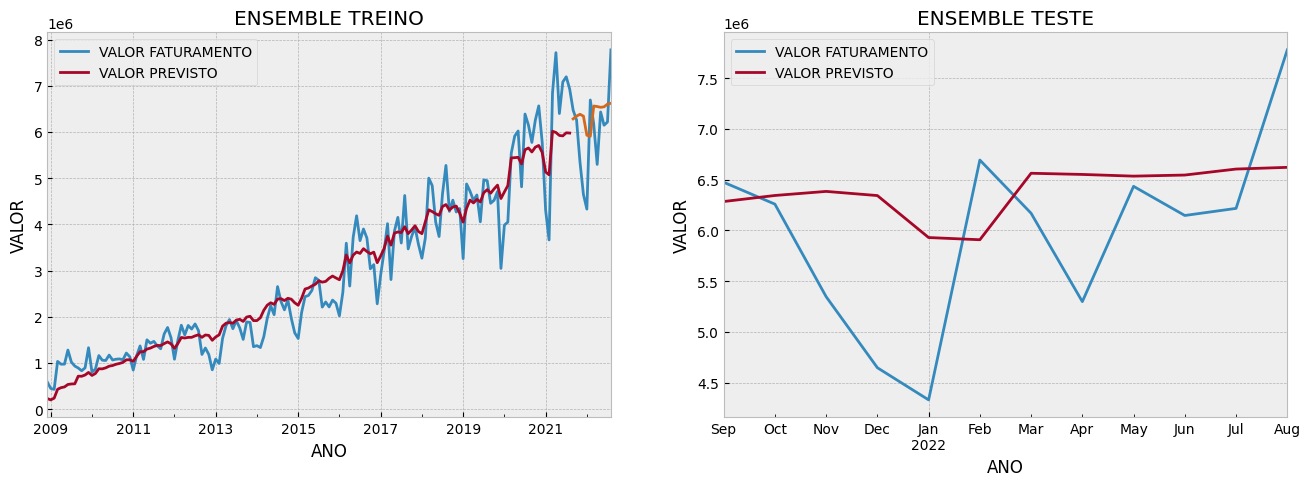

In [145]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
df_ensemble_train["Ensemble"].plot(ax = axes[0])
df_ensemble["Ensemble"].plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
df_ensemble["Ensemble"].plot(ax = axes[1])
axes[0].set_title('ENSEMBLE TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('ENSEMBLE TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
plt.savefig("../ENSEMBLE.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [146]:
Metricas_(df_ensemble["Ensemble"], df_test['VALOR'], 'Ensemble')

(14.000000000000002,
 757039.2248178977,
 937881.4662085775,
 'Ensemble',
 76615487.82)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [147]:
df_Results

Model                 RMSE                  MAE  \
12              Tendência Linear           869,372.88           729,726.87   
11          Tendendia Quadratica         1,246,642.42         1,008,080.03   
10     Transformação Logarítmica         1,633,104.44         1,414,324.86   
9            Simple Smoothing 03         1,198,540.18           957,294.34   
8            Simple Smoothing 05         1,334,673.92         1,119,321.77   
7            Simple Smoothing 08         1,340,795.37         1,126,227.43   
6   Triple Exponential Smoothing         1,389,749.14         1,168,133.52   
5                          ARIMA         1,107,570.18           855,516.48   
4                         SARIMA         1,225,348.78         1,060,648.18   
3                        Prophet           771,914.50           649,893.94   
2                        XGBoost         1,224,219.19           780,785.95   
1                           LSTM         1,097,832.28           787,885.15   
0                       Ensemble           937,881.47           757,039.22   

               MAPE (%)     Valor Anual (R$)  
12                12.69        70,070,915.48  
11                19.14        82,974,067.93  
10                26.30        88,768,133.84  
9                 18.14        81,271,537.72  
8                 21.06        83,604,732.71  
7                 21.18        83,704,174.09  
6                 21.75        84,681,636.74  
5                 16.24        79,577,550.42  
4                 19.19        82,051,858.99  
3                 11.05        70,242,278.77  
2                 13.17        69,379,728.00  
1                 14.92        77,527,696.00  
0                 14.00        76,615,487.82

In [148]:
def highlight_min(s):
    if s.dtype == np.object:
        is_min = [False for _ in range(s.shape[0])]
    else:
        is_min = s == s.min()
    #return ['background: lightgreen' if cell else '' for cell in is_min]
    return ['color:white;background: blue' if cell else '' for cell in is_min]
  
df_Results.style.apply(highlight_min)

# Plot para apresentação final

Plot do VALOR por ANO

2022-10-26 13:19:26.641 WARNING matplotlib.legend: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


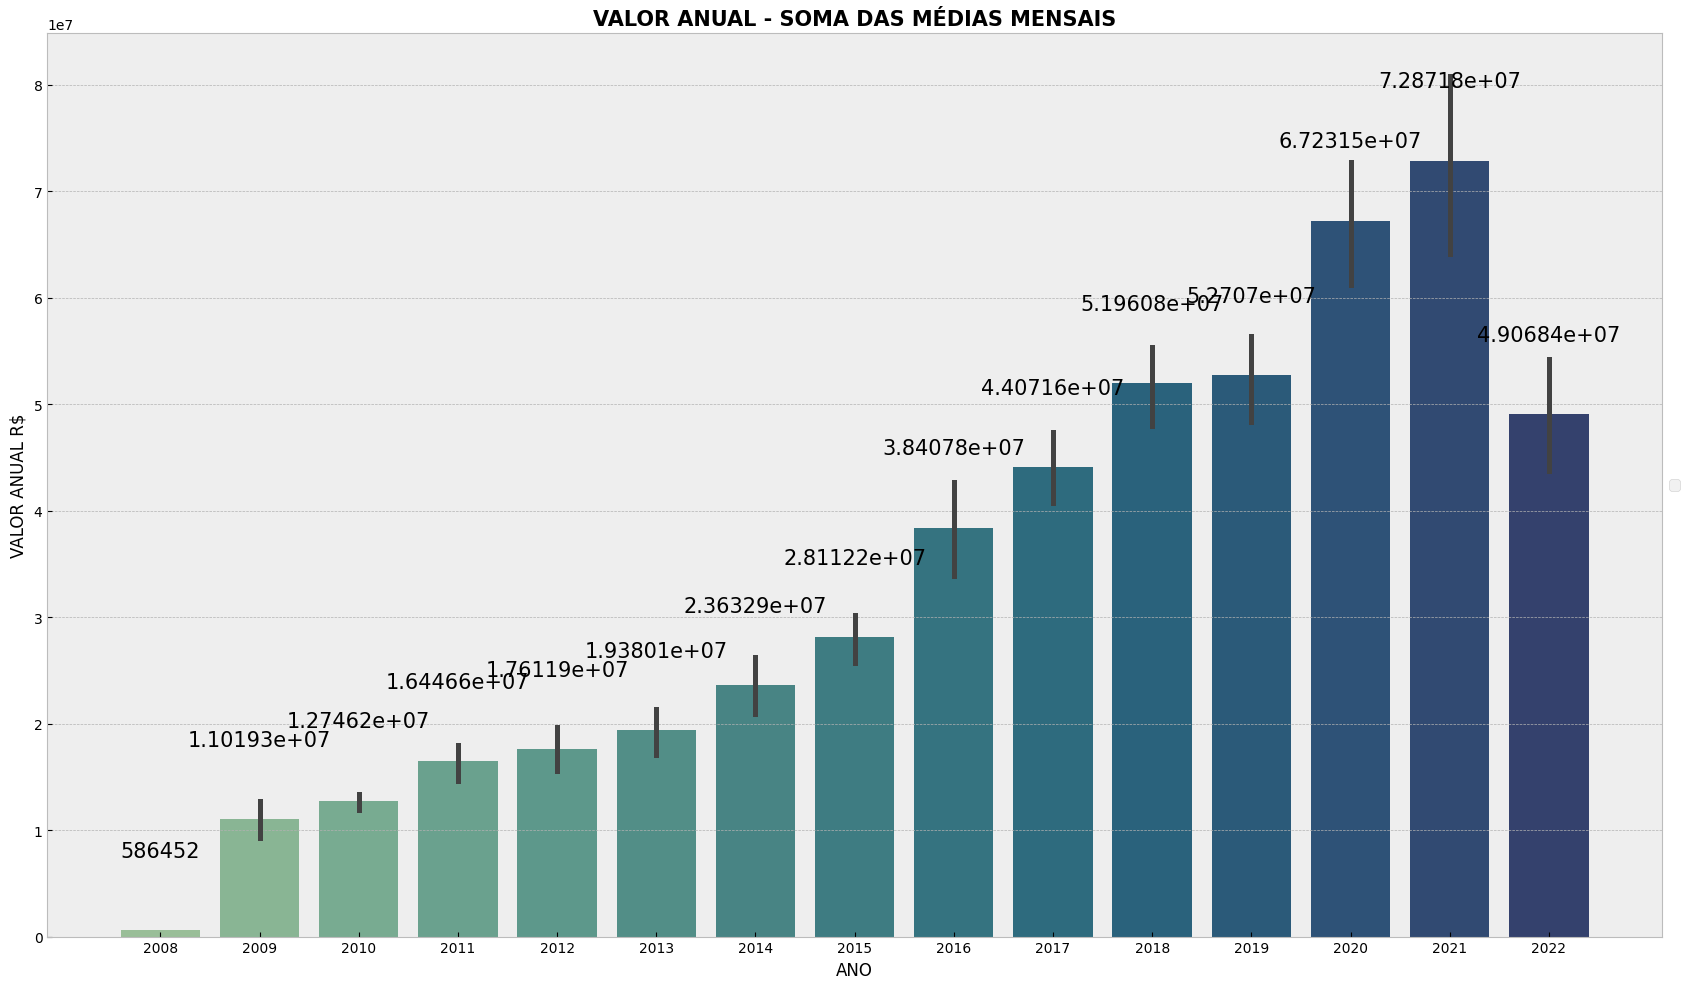

In [149]:
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(17, 10))


ax=sns.barplot(data=dt_ano_sum, x='ANO', y='VALOR', estimator=sum, palette="crest")
#ax.tick_params(left=False, labelleft=False)

for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=50, fontsize=15)
    ax.legend(bbox_to_anchor=(1, .5), loc='center left')
ax.margins(x=0.05) # optionally more space for the text
plt.title('VALOR ANUAL - SOMA DAS MÉDIAS MENSAIS', fontsize=15, weight='bold')
plt.ylabel('VALOR ANUAL R$', size=12)
plt.xlabel('ANO', size=12)
plt.tight_layout()
plt.savefig("../VALOR-ANUAL-FINAL.png", dpi = 600 )
plt.show()

Criação de dataframe para plot da previsão dos modelos Ensemble, LSTM e Tendência Linear

In [150]:
df_Results['Valor Anual (R$)'] = df_Results['Valor Anual (R$)'].round(0)
mask_result= (df_Results['Model'] == 'Ensemble') | (df_Results['Model'] == 'XGBoost') | (df_Results['Model'] == 'Prophet')
df=df_Results[mask_result]

Dataframe para plot resultados valores de test e previstos dos modelos selecionados

In [151]:
df_valor = df.loc[:,['Model','Valor Anual (R$)']]
model="Valor Real (R$)"
valor_real=df_test.VALOR.sum().round(0)
df_valor=df_valor.append({'Model':model, 'Valor Anual (R$)':valor_real}, ignore_index=True)
df_valor

Model     Valor Anual (R$)
0          Prophet        70,242,279.00
1          XGBoost        69,379,728.00
2         Ensemble        76,615,488.00
3  Valor Real (R$)        71,796,235.00

Plot do VALOR previsto dos modelos por ANO

2022-10-26 13:19:29.100 WARNING matplotlib.legend: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


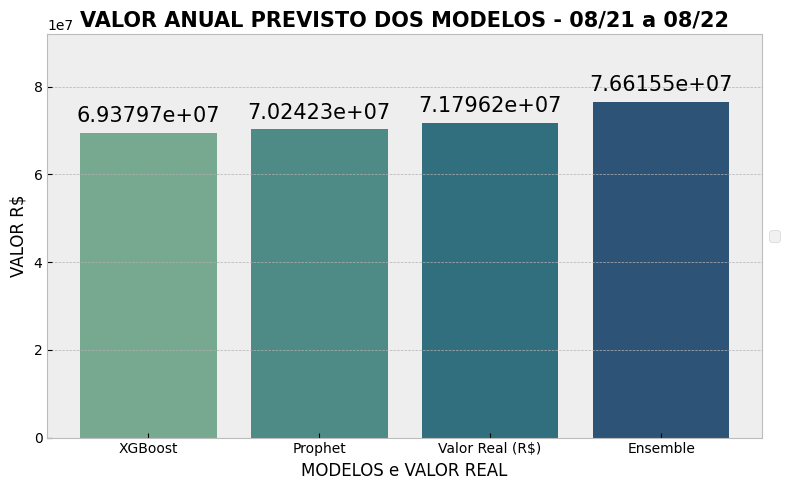

In [152]:
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 5))

ax=sns.barplot(data=df_valor.sort_values(['Valor Anual (R$)']), x="Model", y='Valor Anual (R$)', estimator=sum, palette="crest")

for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=5, fontsize=15)
    ax.legend(bbox_to_anchor=(1, .5), loc='center left')
ax.margins(x=0.05) # optionally more space for the text
plt.margins(y=0.2)
plt.title('VALOR ANUAL PREVISTO DOS MODELOS - 08/21 a 08/22', fontsize=15, weight='bold')
plt.ylabel('VALOR R$', size=12)
plt.xlabel('MODELOS e VALOR REAL', size=12)
plt.tight_layout()
plt.savefig("../VALOR-MODELO-FINAL.png", dpi = 600 )
plt.show()